# Project 2. Flowers images recognition
**Bartosz Stoń & Dominik Raska**

Machine Learning lectured by Pétia Georgieva - University of Aveiro - June 21, 2020

Dataset: Alexander Mamaev. Flowers Recognition V2. https://www.kaggle.com/alxmamaev/flowers-recognition

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import time

from random import randint
from math import ceil
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle

import keras
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, MaxPool2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, ResNet50, InceptionV3, Xception, NASNetLarge, ResNet101V2
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.regularizers import l1,l2

## Data Loading

In [2]:
# Base directory to folder with flowers
base_dir =  r'\Users\fuj\Desktop\_vsb\Semestr 8 - Aveiro\Machine learning\PROJEKT2\flowersNEW'

# Directions for each species
daisy_dir = os.path.join(base_dir, 'daisy')
dandelion_dir = os.path.join(base_dir, 'dandelion')
rose_dir = os.path.join(base_dir, 'rose')
sunflower_dir = os.path.join(base_dir, 'sunflower')
tulip_dir = os.path.join(base_dir, 'tulip')

In [3]:
def loadImages(species, species_dir, IMG_SIZE):
    """
    for each example add image array (size, size, 3) to features (X) and species name to labels (Y)
    """
    for img in os.listdir(species_dir):
        label = species
        path = os.path.join(species_dir, img) 
        img = cv2.imread(path, cv2.IMREAD_COLOR) #Loads a color image. Any transparency of image will be neglected.
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

        X1.append(np.array(img))
        Y1.append(str(label))
        
    print(species + " dataset size: " + str(len(os.listdir(species_dir))))

In [4]:
IMG_SIZE = 150 #the side length of the square image 
X1 = [] #farures
Y1 = [] #labels

loadImages('daisy', daisy_dir, IMG_SIZE)
loadImages('dandelion', dandelion_dir, IMG_SIZE)
loadImages('rose', rose_dir, IMG_SIZE)
loadImages('sunflower', sunflower_dir, IMG_SIZE)
loadImages('tulip', tulip_dir, IMG_SIZE)

daisy dataset size: 747
dandelion dataset size: 1033
rose dataset size: 763
sunflower dataset size: 728
tulip dataset size: 943


In [5]:
print(np.shape(X1))
print(np.shape(Y1))

(4214, 150, 150, 3)
(4214,)


## Ploting subset of data

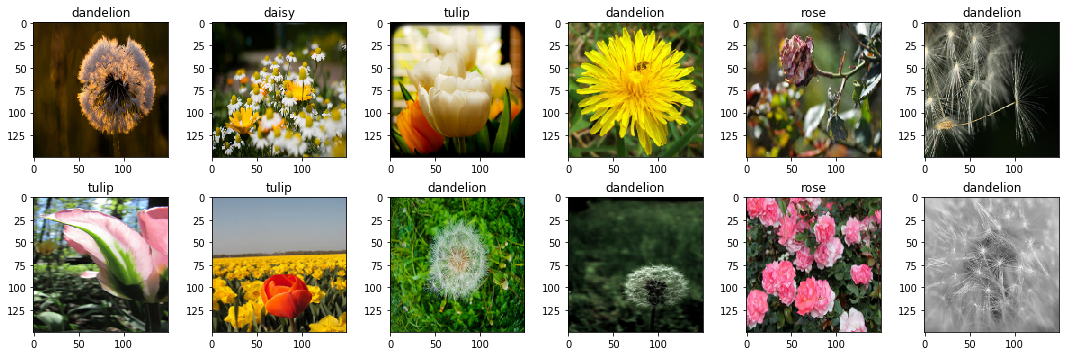

In [54]:
fig, ax = plt.subplots(2, 6)
fig.set_size_inches(15, 5)

for i in range(2):
    for j in range (6):
        rand = randint(0,len(Y1))
        flowerBGR = X1[rand] #image loaded in BGR
        flowerRGB = cv2.cvtColor(flowerBGR, cv2.COLOR_BGR2RGB) #for proper color space in imshow change temporary to RGB
        ax[i,j].imshow(flowerRGB)
        #ax[i,j].imshow(flowerBGR)
        ax[i,j].set_title(str(Y1[rand]))
        
plt.tight_layout()

## Data preparation

In [5]:
X = np.array(X1) # list to array
X = X/255.0
le = LabelEncoder()
Y = le.fit_transform(Y1) # numbers instead of names of species

print(np.shape(X))
print(np.shape(Y))

(4214, 150, 150, 3)
(4214,)


In [6]:
#X = X.reshape(len(X), IMG_SIZE*IMG_SIZE*3) # flatten image
Y = to_categorical(Y, max(Y)+1) # One Hot Encoding

print(np.shape(X))
print(np.shape(Y))

(4214, 150, 150, 3)
(4214, 5)


In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=30, stratify=Y)

print(np.shape(x_train))
print(np.shape(x_test))
print(np.shape(y_train))
print(np.shape(y_test))

(3371, 150, 150, 3)
(843, 150, 150, 3)
(3371, 5)
(843, 5)


## Image data generator

In [8]:
train_datagen = ImageDataGenerator(
    #rescale=1./255, # multiply the data by the value provided (after applying all other transformations)
    rotation_range=45, # range within which to randomly rotate pictures
    width_shift_range=0.2, # randomly translate pictures vertically or horizontally (range as a fraction of total width)
    height_shift_range=0.2, # (range as a fraction of total height)
    shear_range=0.2, # randomly applying shearing transformations
    zoom_range=0.2, # randomly zooming inside pictures
    horizontal_flip=True, # randomly flipping half the images horizontally
    vertical_flip=False, # randomly flipping half the images vertically,
    fill_mode='nearest') # points outside the boundaries of the input are filled according to aaaaaaaaabcd|dddddddd

#val_datagen = ImageDataGenerator(rescale=1./255)

## Augmented examples

C:\Users\fuj\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


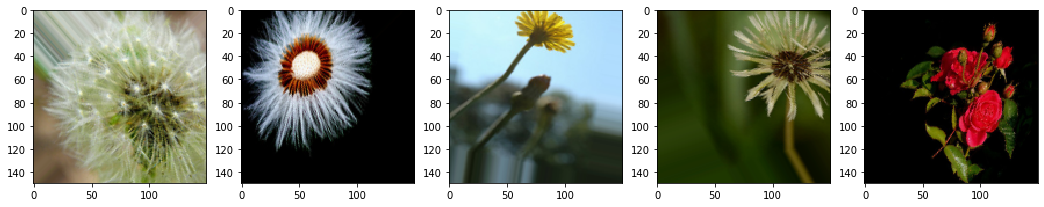

In [82]:
plt.figure(figsize=(18, 18))
plt.subplot(151)
i = 1
for batch in train_datagen.flow(X, batch_size=1):
    plt.subplot(1,5,i)
    plt.imshow(cv2.cvtColor(batch[0], cv2.COLOR_BGR2RGB))
    i += 1
    if i % 6 == 0:
        break
plt.show()

## k-fold and training implementation

In [9]:
def k_fold_split_ranges(ranges, num):
    """
    determine k-fold ranges
    """
    avg = len(ranges) / float(num)
    out = []
    last = 0.0
    while last < len(ranges):
        out.append(ranges[int(last):int(last + avg)])
        last += avg
    return out

In [56]:
plt.rcParams.update({'font.size': 12})

def k_fold_validation(X, Y, model_no, k, alfa, Lambda, epochs, batch_size):
    """
    train and validate model for each k-fold; print and plot all results; return final averaged result
    """
    # select model to use - mapping to function with correct model
    dispatcher={'model_1':model_1, 'model_2':model_2, 'model_3':model_3, 'model_4':model_4, 'model_5':model_5
                , 'model_6':model_6, 'model_7':model_7, 'model_VGG':model_VGG, 'model_VGG2':model_VGG2
                , 'model_VGG2_SGD':model_VGG2_SGD, 'model_VGG2_RMS':model_VGG2_RMS
                , 'model_VGG3':model_VGG3,'model_VGG4':model_VGG4, 'model_Xception':model_Xception, 'model_Xception2':model_Xception2}
    try:
        createModel=dispatcher[model_no]
    except KeyError:
        raise ValueError('invalid input')

    print('[INFO] Performing ' + str(k) + '-fold validation...')
    
    samples = np.shape(X)[0]  # Total size of the data set
    folds = k_fold_split_ranges(range(0, samples), k) # Split data into k folds (Cross-validation sets)
    
    # lists to collect metrics for every kfold
    fold_acc=[]
    fold_loss=[]
    
    # plot loss and accuracy for training and validation data
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)

    ax[0].set_title('Model Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epochs')
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylim(0,1)
    ax[0].grid(True)
    ax[1].grid(True)
    for kfold in range(0, k): # Iterate through each fold
        
        print('------------------------------------------------------------------------')
        print('[INFO] Training for fold no ' + str(kfold))
        
        start = folds[kfold][0] # first index of the fold
        end = folds[kfold][np.size(folds[kfold])-1]  # last index of the fold             
        x_tr = np.concatenate((X[:start], X[end:])) # Obtain training set by omitting current fold   
        y_tr = np.concatenate((Y[:start], Y[end:]))
        x_val = X[start:end]  # obtain validation set
        y_val = Y[start:end]
        
        # Model training 
        model = createModel(x_tr, y_tr, alfa, Lambda) # create the chosen model
        history = model.fit(train_datagen.flow(x_tr, y_tr, batch_size=batch_size), epochs=epochs,
                            steps_per_epoch=ceil(len(x_tr)/batch_size), verbose=1,
                            validation_data=(x_val, y_val),
                            validation_steps=ceil(len(x_tr)/batch_size))
                            # verbose - method of progress printing
        (loss, accuracy) = model.evaluate(x_val, y_val, verbose=0) # Get evaluation for current fold
        # add loss and accuracy value to table with values for other kfolds
        fold_acc.append(accuracy * 100)
        fold_loss.append(loss)
        
        # add loss and accuracy lines to plot
        ax[0].plot(history.history['loss'], 'b', label = 'train')
        ax[0].plot(history.history['val_loss'], 'r', label = 'val')
        ax[1].plot(history.history['categorical_accuracy'], 'b', label = 'train')
        ax[1].plot(history.history['val_categorical_accuracy'], 'r', label = 'val')

    handles, labels = ax[0].get_legend_handles_labels()
    ax[0].legend(handles, ('train', 'validation'))
    handles, labels = ax[1].get_legend_handles_labels()
    ax[1].legend(handles, ('train', 'validation')) 
    print('------------------------------------------------------------------------') 
    # print final - averaged metrics
    print(f'[INFO] Average scores for all folds: loss - {np.mean(fold_loss)}; accuracy - {np.mean(fold_acc)}%')
    plt.savefig(model_no + '.' + str(time.time()) + '.pdf')
    return np.mean(fold_acc), np.mean(fold_loss), model

## Models

In [11]:
def model_1(x_tr, y_tr, alfa, Lambda):
    # define the architecture of the network
    model = Sequential()
    # 1st Convolutional Layer
    model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(x_tr.shape[1], x_tr.shape[2], 3)))
    model.add(MaxPooling2D((2, 2)))
    # 2nd Convolutional Layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # 3rd Convolutional Layer
    model.add(Conv2D(96, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # 4th Convolutional Layer
    model.add(Conv2D(96, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # Flatten
    model.add(Flatten())
    # 1st Fully Connected Layer
    model.add(Dense(512, activation='relu'))
    # Output layer
    model.add(Dense(5, activation="softmax"))

    # lr - learning rate
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=alfa), metrics=["categorical_accuracy"])
    #print(model.summary())
    return model

In [12]:
def model_2(x_tr, y_tr, alfa, Lambda):
    # define the architecture of the network
    model = Sequential()
    # 1st Convolutional Layer
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(x_tr.shape[1], x_tr.shape[2], 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    # 2nd Convolutional Layer
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    # 3rd Convolutional Layer
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    # 4th Convolutional Layer
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    # Flatten
    model.add(layers.Flatten())
    # 1st Fully Connected Layer
    model.add(layers.Dense(512, activation='relu'))
    # Output layer
    model.add(Dense(5,activation="softmax"))

    # lr - learning rate
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=alfa), metrics=["categorical_accuracy"])
    #print(model.summary())
    return model    

In [13]:
def model_3(x_tr, y_tr, alfa, Lambda):
    # define the architecture of the network
    model = Sequential()
    # 1st Convolutional Layer
    model.add(Conv2D(64, (3,3), activation="relu", input_shape=(x_tr.shape[1], x_tr.shape[2], 3)))
    model.add(MaxPooling2D((2, 2)))
    # 2nd Convolutional Layer
    model.add(Conv2D(128, (3,3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    # 3rd Convolutional Layer
    model.add(Conv2D(128, (3,3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    # 4th Convolutional Layer
    model.add(Conv2D(256, (3,3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    # 5th Convolutional Layer
    model.add(Conv2D(512, (3,3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    # Flatten
    model.add(Flatten())
    # 1st Fully Connected Layer
    model.add(Dense(1024,activation="relu"))
    # Output layer
    model.add(Dense(5,activation="softmax"))

    # lr - learning rate
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=alfa), metrics=["categorical_accuracy"])
    #print(model.summary())
    return model

## Models (2) - Adding Droupout and Batch normalization

In [14]:
def model_4(x_tr, y_tr, alfa, Lambda):
    # define the architecture of the network
    model = Sequential()
    # 1st Convolutional Layer
    model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(x_tr.shape[1], x_tr.shape[2], 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    # 2nd Convolutional Layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    # 3rd Convolutional Layer
    model.add(Conv2D(96, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    # 4th Convolutional Layer
    model.add(Conv2D(96, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    # Flatten
    model.add(Flatten())
    model.add(Dropout(0.5))
    # 1st Fully Connected Layer
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    # Output layer
    model.add(Dense(5, activation="softmax"))

    # lr - learning rate
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=alfa), metrics=["categorical_accuracy"])
    #print(model.summary())
    return model

In [15]:
def model_5(x_tr, y_tr, alfa, Lambda):
    # define the architecture of the network
    model = Sequential()
    # 1st Convolutional Layer
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(x_tr.shape[1], x_tr.shape[2], 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    # 2nd Convolutional Layer
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    # 3rd Convolutional Layer
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    # 4th Convolutional Layer
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    # Flatten
    model.add(layers.Flatten())
    model.add(Dropout(0.5))
    # 1st Fully Connected Layer
    model.add(layers.Dense(512, activation='relu'))
    model.add(BatchNormalization())
    # Output layer
    model.add(Dense(5,activation="softmax"))

    # lr - learning rate
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=alfa), metrics=["categorical_accuracy"])
    #print(model.summary())
    return model    

In [16]:
def model_6(x_tr, y_tr, alfa, Lambda):
    # define the architecture of the network
    model = Sequential()
    # 1st Convolutional Layer
    model.add(Conv2D(64, (3,3), activation="relu", input_shape=(x_tr.shape[1], x_tr.shape[2], 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    # 2nd Convolutional Layer
    model.add(Conv2D(128, (3,3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    # 3rd Convolutional Layer
    model.add(Conv2D(128, (3,3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    # 4th Convolutional Layer
    model.add(Conv2D(256, (3,3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    # 5th Convolutional Layer
    model.add(Conv2D(512, (3,3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    # Flatten
    model.add(Flatten())
    model.add(Dropout(0.5))
    # 1st Fully Connected Layer
    model.add(Dense(1024,activation="relu"))
    model.add(BatchNormalization())
    # Output layer
    model.add(Dense(5,activation="softmax"))

    # lr - learning rate
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=alfa), metrics=["categorical_accuracy"])
    #print(model.summary())
    return model

In [17]:
def model_7(x_tr, y_tr, alfa, Lambda):
    # define the architecture of the network
    model = Sequential()
    # 1st Convolutional Layer
    model.add(Conv2D(64, (3,3), activation="relu", input_shape=(x_tr.shape[1], x_tr.shape[2], 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    # 2nd Convolutional Layer
    model.add(Conv2D(128, (3,3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    # 3rd Convolutional Layer
    model.add(Conv2D(128, (3,3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    # 4th Convolutional Layer
    model.add(Conv2D(256, (3,3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    # 5th Convolutional Layer
    model.add(Conv2D(512, (3,3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    # Flatten
    model.add(Flatten())
    # 1st Fully Connected Layer
    model.add(Dense(1024,activation="relu"))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    # Output layer
    model.add(Dense(5,activation="softmax"))

    # lr - learning rate
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=alfa), metrics=["categorical_accuracy"])
    #print(model.summary())
    return model

In [18]:
def model_VGG(x_tr, y_tr, alfa, Lambda):
    input_shape = x_tr.shape[1:]
    pretrained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    pretrained_model.trainable = False
    
    X_input = Input(input_shape)
    X = pretrained_model(X_input)
    X = MaxPooling2D((2, 2), name='max_pool')(X)
    X = Flatten()(X)
    X = Dense(5, activation='softmax', name='fc')(X)
    
    # Create model.
    model = Model(inputs = X_input, outputs = X, name='FlowerModel')
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=alfa), metrics=["categorical_accuracy"])
    
    return model

In [19]:
def model_VGG2(x_tr, y_tr, alfa, Lambda):
    input_shape = x_tr.shape[1:]
    pretrained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    pretrained_model.trainable = False 
    
    X_input = Input(input_shape)
    X = pretrained_model(X_input)
    X = MaxPooling2D((2, 2), name='max_pool')(X)
    X = Flatten()(X)
    X = Dense(4096, activation="relu")(X)
    X = Dense(5, activation='softmax', name='fc')(X)
    
    # Create model.
    model = Model(inputs = X_input, outputs = X, name='FlowerModel')
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=alfa), metrics=["categorical_accuracy"])
    
    return model

In [20]:
def model_VGG2_RMS(x_tr, y_tr, alfa, Lambda):
    input_shape = x_tr.shape[1:]
    pretrained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    pretrained_model.trainable = False 
    
    X_input = Input(input_shape)
    X = pretrained_model(X_input)
    X = MaxPooling2D((2, 2), name='max_pool')(X)
    X = Flatten()(X)
    X = Dense(4096, activation="relu")(X)
    X = Dense(5, activation='softmax', name='fc')(X)
    
    # Create model.
    model = Model(inputs = X_input, outputs = X, name='FlowerModel')
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=alfa), metrics=["categorical_accuracy"])
    
    return model

In [21]:
def model_VGG2_SGD(x_tr, y_tr, alfa, Lambda):
    input_shape = x_tr.shape[1:]
    pretrained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    pretrained_model.trainable = False 
    
    X_input = Input(input_shape)
    X = pretrained_model(X_input)
    X = MaxPooling2D((2, 2), name='max_pool')(X)
    X = Flatten()(X)
    X = Dense(4096, activation="relu")(X)
    X = Dense(5, activation='softmax', name='fc')(X)
    
    # Create model.
    model = Model(inputs = X_input, outputs = X, name='FlowerModel')
    model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=alfa), metrics=["categorical_accuracy"])
    
    return model

In [27]:
def model_VGG3(x_tr, y_tr, alfa, Lambda):
    input_shape = x_tr.shape[1:]
    pretrained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    pretrained_model.trainable = False 
    
    X_input = Input(input_shape)
    X = pretrained_model(X_input)
    X = MaxPooling2D((2, 2), name='max_pool')(X)
    X = Flatten()(X)
    X = Dense(4096, activation="relu")(X)
    X = Dropout(0.25)(X)
    X = Dense(512, activation="relu")(X)
    X = Dense(5, activation='softmax', name='fc')(X)
    
    # Create model.
    model = Model(inputs = X_input, outputs = X, name='FlowerModel')
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=alfa), metrics=["categorical_accuracy"])
    print(model.summary())
    return model

In [ ]:
def model_VGG4(x_tr, y_tr, alfa, Lambda):
    input_shape = x_tr.shape[1:]
    pretrained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    pretrained_model.trainable = False 
    
    X_input = Input(input_shape)
    X = pretrained_model(X_input)
    X = MaxPooling2D((2, 2), name='max_pool')(X)
    X = Flatten()(X)
    X = Dense(512, activation="relu")(X)
    X = Dropout(0.5)(X)
    X = Dense(512, activation="relu")(X)
    X = Dropout(0.5)(X)
    X = Dense(5, activation='softmax', name='fc')(X)
    
    # Create model.
    model = Model(inputs = X_input, outputs = X, name='FlowerModel')
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=alfa), metrics=["categorical_accuracy"])
    print(model.summary())
    return model

In [24]:
def model_Xception(x_tr, y_tr, alfa, Lambda):
    input_shape = x_tr.shape[1:]
    pretrained_model = Xception(input_shape=input_shape, include_top=False, weights="imagenet")
    pretrained_model.trainable = False 
    
    X_input = Input(input_shape)
    X = pretrained_model(X_input)
    X = MaxPooling2D((2, 2), name='max_pool')(X)
    X = Flatten()(X)
    X = Dense(5, activation='softmax', name='fc')(X)
    
    # Create model.
    model = Model(inputs = X_input, outputs = X, name='FlowerModel')
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=alfa), metrics=["categorical_accuracy"])
    
    return model

In [25]:
def model_Xception2(x_tr, y_tr, alfa, Lambda):
    input_shape = x_tr.shape[1:]
    pretrained_model = Xception(input_shape=input_shape, include_top=False, weights="imagenet")
    pretrained_model.trainable = False 
    
    X_input = Input(input_shape)
    X = pretrained_model(X_input)
    X = MaxPooling2D((2, 2), name='max_pool')(X)
    X = Flatten()(X)
    X = Dense(4096, activation='relu', name='fc')(X)
    X = Dense(2048, activation='relu', name='fc2')(X)
    X = Dense(5, activation='softmax', name='soft')(X)
    
    # Create model.
    model = Model(inputs = X_input, outputs = X, name='FlowerModel')
    model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=alfa), metrics=["categorical_accuracy"])
    
    return model

## Cross vaidation

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Epoch 1/40
88/88 [==============================] - 11s 125ms/step - loss: 1.4067 - categorical_accuracy: 0.3632 - val_loss: 1.1843 - val_categorical_accuracy: 0.5107
Epoch 2/40
88/88 [==============================] - 11s 126ms/step - loss: 1.1426 - categorical_accuracy: 0.5258 - val_loss: 1.1372 - val_categorical_accuracy: 0.5679
Epoch 3/40
88/88 [==============================] - 11s 125ms/step - loss: 1.0385 - categorical_accuracy: 0.5731 - val_loss: 1.0198 - val_categorical_accuracy: 0.5804
Epoch 4/40
88/88 [==============================] - 10s 119ms/step - loss: 0.9979 - categorical_accuracy: 0.5937 - val_loss: 1.7229 - val_categorical_accuracy: 0.4071
Epoch 5/40
88/88 [==============================] - 10s 119ms/step - loss: 0.9793 - categorical_accuracy: 0.6186 - val_loss: 0.9373 - val_categorical_accuracy: 0.6571
Epoch 6/40
88/88 [=====

88/88 [==============================] - 10s 118ms/step - loss: 0.6712 - categorical_accuracy: 0.7477 - val_loss: 0.7494 - val_categorical_accuracy: 0.7380
Epoch 17/40
88/88 [==============================] - 10s 118ms/step - loss: 0.6565 - categorical_accuracy: 0.7477 - val_loss: 0.8783 - val_categorical_accuracy: 0.7041
Epoch 18/40
88/88 [==============================] - 10s 116ms/step - loss: 0.6743 - categorical_accuracy: 0.7402 - val_loss: 0.6948 - val_categorical_accuracy: 0.7522
Epoch 19/40
88/88 [==============================] - 10s 117ms/step - loss: 0.6539 - categorical_accuracy: 0.7623 - val_loss: 0.7044 - val_categorical_accuracy: 0.7594
Epoch 20/40
88/88 [==============================] - 10s 118ms/step - loss: 0.6195 - categorical_accuracy: 0.7651 - val_loss: 0.7415 - val_categorical_accuracy: 0.7184
Epoch 21/40
88/88 [==============================] - 10s 117ms/step - loss: 0.6141 - categorical_accuracy: 0.7669 - val_loss: 0.7423 - val_categorical_accuracy: 0.7308
Epoc

88/88 [==============================] - 10s 117ms/step - loss: 0.4946 - categorical_accuracy: 0.8071 - val_loss: 0.7049 - val_categorical_accuracy: 0.7594
Epoch 33/40
88/88 [==============================] - 10s 116ms/step - loss: 0.4894 - categorical_accuracy: 0.8146 - val_loss: 0.5961 - val_categorical_accuracy: 0.7968
Epoch 34/40
88/88 [==============================] - 10s 117ms/step - loss: 0.4738 - categorical_accuracy: 0.8181 - val_loss: 0.6810 - val_categorical_accuracy: 0.7576
Epoch 35/40
88/88 [==============================] - 10s 118ms/step - loss: 0.4720 - categorical_accuracy: 0.8228 - val_loss: 0.5633 - val_categorical_accuracy: 0.8075
Epoch 36/40
88/88 [==============================] - 10s 116ms/step - loss: 0.4917 - categorical_accuracy: 0.8110 - val_loss: 0.5247 - val_categorical_accuracy: 0.8004
Epoch 37/40
88/88 [==============================] - 10s 118ms/step - loss: 0.4641 - categorical_accuracy: 0.8199 - val_loss: 0.5819 - val_categorical_accuracy: 0.7772
Epoc

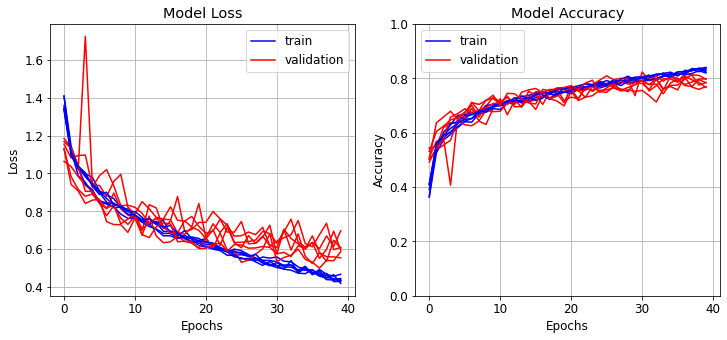

In [135]:
# Model 1 k-fold validation
k = 6 # number of folds
alfa = 0.001 # learning rate
Lambda = 0 # regularizer
epochs = 40
batch_size = 32
acc1, loss1, model1 = k_fold_validation(x_train, y_train, 'model_1', k, alfa, Lambda, epochs, batch_size)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Epoch 1/40
88/88 [==============================] - 11s 125ms/step - loss: 1.3379 - categorical_accuracy: 0.4034 - val_loss: 1.1887 - val_categorical_accuracy: 0.5000
Epoch 2/40
88/88 [==============================] - 10s 116ms/step - loss: 1.0873 - categorical_accuracy: 0.5422 - val_loss: 1.1195 - val_categorical_accuracy: 0.5732
Epoch 3/40
88/88 [==============================] - 10s 117ms/step - loss: 1.0112 - categorical_accuracy: 0.5784 - val_loss: 0.9619 - val_categorical_accuracy: 0.6071
Epoch 4/40
88/88 [==============================] - 10s 117ms/step - loss: 0.9176 - categorical_accuracy: 0.6304 - val_loss: 0.9776 - val_categorical_accuracy: 0.6250
Epoch 5/40
88/88 [==============================] - 10s 118ms/step - loss: 0.8794 - categorical_accuracy: 0.6624 - val_loss: 0.9226 - val_categorical_accuracy: 0.6643
Epoch 6/40
88/88 [=====

88/88 [==============================] - 10s 117ms/step - loss: 0.6291 - categorical_accuracy: 0.7552 - val_loss: 0.8286 - val_categorical_accuracy: 0.7023
Epoch 17/40
88/88 [==============================] - 10s 118ms/step - loss: 0.6451 - categorical_accuracy: 0.7423 - val_loss: 0.7322 - val_categorical_accuracy: 0.7130
Epoch 18/40
88/88 [==============================] - 10s 117ms/step - loss: 0.5966 - categorical_accuracy: 0.7730 - val_loss: 0.5984 - val_categorical_accuracy: 0.7950
Epoch 19/40
88/88 [==============================] - 10s 116ms/step - loss: 0.5973 - categorical_accuracy: 0.7719 - val_loss: 0.6490 - val_categorical_accuracy: 0.7415
Epoch 20/40
88/88 [==============================] - 10s 118ms/step - loss: 0.5971 - categorical_accuracy: 0.7712 - val_loss: 0.6800 - val_categorical_accuracy: 0.7701
Epoch 21/40
88/88 [==============================] - 10s 117ms/step - loss: 0.5584 - categorical_accuracy: 0.7826 - val_loss: 0.7334 - val_categorical_accuracy: 0.7415
Epoc

88/88 [==============================] - 10s 118ms/step - loss: 0.4668 - categorical_accuracy: 0.8146 - val_loss: 0.5730 - val_categorical_accuracy: 0.7861
Epoch 33/40
88/88 [==============================] - 10s 116ms/step - loss: 0.4531 - categorical_accuracy: 0.8342 - val_loss: 0.5806 - val_categorical_accuracy: 0.8146
Epoch 34/40
88/88 [==============================] - 10s 117ms/step - loss: 0.4405 - categorical_accuracy: 0.8310 - val_loss: 0.6478 - val_categorical_accuracy: 0.7790
Epoch 35/40
88/88 [==============================] - 10s 118ms/step - loss: 0.4260 - categorical_accuracy: 0.8434 - val_loss: 0.5807 - val_categorical_accuracy: 0.8039
Epoch 36/40
88/88 [==============================] - 10s 116ms/step - loss: 0.4043 - categorical_accuracy: 0.8470 - val_loss: 0.6584 - val_categorical_accuracy: 0.8075
Epoch 37/40
88/88 [==============================] - 10s 116ms/step - loss: 0.4168 - categorical_accuracy: 0.8399 - val_loss: 0.6313 - val_categorical_accuracy: 0.7825
Epoc

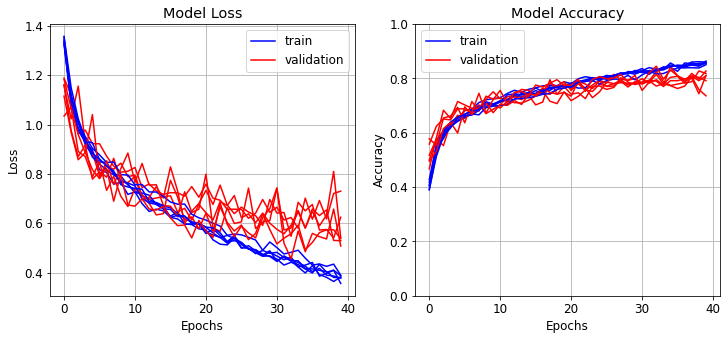

In [136]:
# Model 2 k-fold validation
k = 6 # number of folds
alfa = 0.001 # learning rate
Lambda = 0 # regularizer
epochs = 40
batch_size = 32
acc2, loss2, model2 = k_fold_validation(x_train, y_train, 'model_2', k, alfa, Lambda, epochs, batch_size)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Epoch 1/40
88/88 [==============================] - 11s 128ms/step - loss: 1.3881 - categorical_accuracy: 0.3611 - val_loss: 1.4016 - val_categorical_accuracy: 0.3875
Epoch 2/40
88/88 [==============================] - 10s 115ms/step - loss: 1.1861 - categorical_accuracy: 0.4856 - val_loss: 1.2482 - val_categorical_accuracy: 0.4393
Epoch 3/40
88/88 [==============================] - 10s 117ms/step - loss: 1.1028 - categorical_accuracy: 0.5521 - val_loss: 1.1475 - val_categorical_accuracy: 0.5643
Epoch 4/40
88/88 [==============================] - 10s 118ms/step - loss: 1.0235 - categorical_accuracy: 0.6048 - val_loss: 0.9593 - val_categorical_accuracy: 0.6429
Epoch 5/40
88/88 [==============================] - 10s 118ms/step - loss: 0.9558 - categorical_accuracy: 0.6215 - val_loss: 1.0226 - val_categorical_accuracy: 0.5589
Epoch 6/40
88/88 [=====

88/88 [==============================] - 10s 118ms/step - loss: 0.7274 - categorical_accuracy: 0.7249 - val_loss: 0.6982 - val_categorical_accuracy: 0.7380
Epoch 17/40
88/88 [==============================] - 10s 119ms/step - loss: 0.6732 - categorical_accuracy: 0.7452 - val_loss: 0.7311 - val_categorical_accuracy: 0.7148
Epoch 18/40
88/88 [==============================] - 10s 117ms/step - loss: 0.6582 - categorical_accuracy: 0.7416 - val_loss: 0.7445 - val_categorical_accuracy: 0.7184
Epoch 19/40
88/88 [==============================] - 10s 117ms/step - loss: 0.6414 - categorical_accuracy: 0.7544 - val_loss: 0.7028 - val_categorical_accuracy: 0.7504
Epoch 20/40
88/88 [==============================] - 10s 119ms/step - loss: 0.6553 - categorical_accuracy: 0.7484 - val_loss: 0.6821 - val_categorical_accuracy: 0.7576
Epoch 21/40
88/88 [==============================] - 10s 117ms/step - loss: 0.6390 - categorical_accuracy: 0.7544 - val_loss: 0.7514 - val_categorical_accuracy: 0.7077
Epoc

88/88 [==============================] - 10s 118ms/step - loss: 0.5091 - categorical_accuracy: 0.8039 - val_loss: 0.7674 - val_categorical_accuracy: 0.7415
Epoch 33/40
88/88 [==============================] - 10s 117ms/step - loss: 0.5321 - categorical_accuracy: 0.7996 - val_loss: 0.6394 - val_categorical_accuracy: 0.7487
Epoch 34/40
88/88 [==============================] - 10s 118ms/step - loss: 0.5005 - categorical_accuracy: 0.8071 - val_loss: 0.6110 - val_categorical_accuracy: 0.7914
Epoch 35/40
88/88 [==============================] - 10s 119ms/step - loss: 0.4990 - categorical_accuracy: 0.8121 - val_loss: 0.5757 - val_categorical_accuracy: 0.8021
Epoch 36/40
88/88 [==============================] - 10s 116ms/step - loss: 0.4790 - categorical_accuracy: 0.8174 - val_loss: 0.6187 - val_categorical_accuracy: 0.7790
Epoch 37/40
88/88 [==============================] - 10s 117ms/step - loss: 0.5017 - categorical_accuracy: 0.8068 - val_loss: 0.6326 - val_categorical_accuracy: 0.7754
Epoc

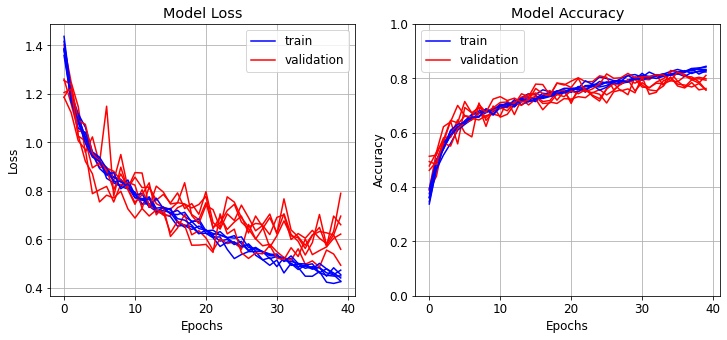

In [137]:
# Model 3 k-fold validation
k = 6 # number of folds
alfa = 0.001 # learning rate
Lambda = 0 # regularizer
epochs = 40
batch_size = 32
acc3, loss3, model3 = k_fold_validation(x_train, y_train, 'model_3', k, alfa, Lambda, epochs, batch_size)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Epoch 1/40
88/88 [==============================] - 11s 125ms/step - loss: 1.5612 - categorical_accuracy: 0.4931 - val_loss: 2.7147 - val_categorical_accuracy: 0.2464
Epoch 2/40
88/88 [==============================] - 10s 118ms/step - loss: 1.0946 - categorical_accuracy: 0.5792 - val_loss: 2.6267 - val_categorical_accuracy: 0.2482
Epoch 3/40
88/88 [==============================] - 10s 118ms/step - loss: 1.0525 - categorical_accuracy: 0.5930 - val_loss: 2.1116 - val_categorical_accuracy: 0.3107
Epoch 4/40
88/88 [==============================] - 10s 119ms/step - loss: 0.9890 - categorical_accuracy: 0.6250 - val_loss: 1.6473 - val_categorical_accuracy: 0.3589
Epoch 5/40
88/88 [==============================] - 11s 120ms/step - loss: 0.9322 - categorical_accuracy: 0.6307 - val_loss: 1.3313 - val_categorical_accuracy: 0.4554
Epoch 6/40
88/88 [=====

88/88 [==============================] - 11s 120ms/step - loss: 0.7421 - categorical_accuracy: 0.7217 - val_loss: 0.9462 - val_categorical_accuracy: 0.6578
Epoch 17/40
88/88 [==============================] - 11s 120ms/step - loss: 0.7234 - categorical_accuracy: 0.7221 - val_loss: 2.5280 - val_categorical_accuracy: 0.4795
Epoch 18/40
88/88 [==============================] - 10s 118ms/step - loss: 0.7122 - categorical_accuracy: 0.7352 - val_loss: 1.1348 - val_categorical_accuracy: 0.6061
Epoch 19/40
88/88 [==============================] - 10s 118ms/step - loss: 0.6957 - categorical_accuracy: 0.7359 - val_loss: 0.9038 - val_categorical_accuracy: 0.6738
Epoch 20/40
88/88 [==============================] - 11s 119ms/step - loss: 0.6777 - categorical_accuracy: 0.7327 - val_loss: 0.9518 - val_categorical_accuracy: 0.6631
Epoch 21/40
88/88 [==============================] - 10s 117ms/step - loss: 0.6749 - categorical_accuracy: 0.7477 - val_loss: 0.7634 - val_categorical_accuracy: 0.7433
Epoc

88/88 [==============================] - 11s 119ms/step - loss: 0.5774 - categorical_accuracy: 0.7861 - val_loss: 0.9630 - val_categorical_accuracy: 0.7059
Epoch 33/40
88/88 [==============================] - 10s 117ms/step - loss: 0.5719 - categorical_accuracy: 0.7840 - val_loss: 0.6270 - val_categorical_accuracy: 0.7594
Epoch 34/40
88/88 [==============================] - 10s 118ms/step - loss: 0.5347 - categorical_accuracy: 0.8014 - val_loss: 0.8185 - val_categorical_accuracy: 0.6988
Epoch 35/40
88/88 [==============================] - 11s 120ms/step - loss: 0.5424 - categorical_accuracy: 0.7975 - val_loss: 0.7183 - val_categorical_accuracy: 0.7308
Epoch 36/40
88/88 [==============================] - 10s 117ms/step - loss: 0.5187 - categorical_accuracy: 0.8071 - val_loss: 0.5707 - val_categorical_accuracy: 0.8004
Epoch 37/40
88/88 [==============================] - 10s 118ms/step - loss: 0.5101 - categorical_accuracy: 0.8085 - val_loss: 0.5791 - val_categorical_accuracy: 0.7772
Epoc

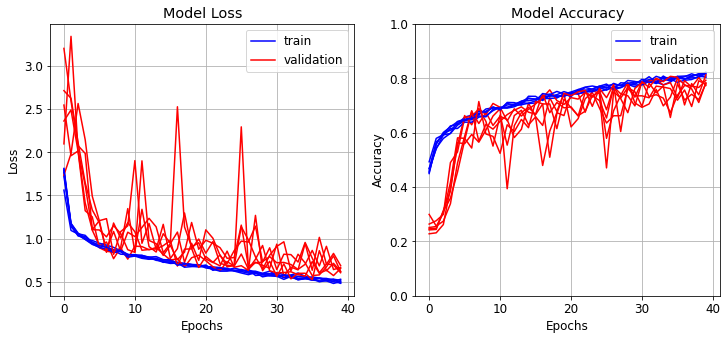

In [138]:
# Model 4 k-fold validation
k = 6 # number of folds
alfa = 0.001 # learning rate
Lambda = 0 # regularizer
epochs = 40
batch_size = 32
acc4, loss4, model4 = k_fold_validation(x_train, y_train, 'model_4', k, alfa, Lambda, epochs, batch_size)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Epoch 1/40
88/88 [==============================] - 11s 125ms/step - loss: 1.7384 - categorical_accuracy: 0.4945 - val_loss: 2.8464 - val_categorical_accuracy: 0.2446
Epoch 2/40
88/88 [==============================] - 10s 118ms/step - loss: 1.0932 - categorical_accuracy: 0.5916 - val_loss: 3.0100 - val_categorical_accuracy: 0.2446
Epoch 3/40
88/88 [==============================] - 10s 118ms/step - loss: 1.0176 - categorical_accuracy: 0.6026 - val_loss: 2.4083 - val_categorical_accuracy: 0.2518
Epoch 4/40
88/88 [==============================] - 10s 119ms/step - loss: 0.9365 - categorical_accuracy: 0.6290 - val_loss: 1.9377 - val_categorical_accuracy: 0.3250
Epoch 5/40
88/88 [==============================] - 11s 120ms/step - loss: 0.9152 - categorical_accuracy: 0.6510 - val_loss: 1.3578 - val_categorical_accuracy: 0.5196
Epoch 6/40
88/88 [=====

88/88 [==============================] - 10s 118ms/step - loss: 0.6762 - categorical_accuracy: 0.7459 - val_loss: 1.5815 - val_categorical_accuracy: 0.5401
Epoch 17/40
88/88 [==============================] - 11s 121ms/step - loss: 0.6849 - categorical_accuracy: 0.7477 - val_loss: 0.7618 - val_categorical_accuracy: 0.7023
Epoch 18/40
88/88 [==============================] - 10s 117ms/step - loss: 0.6903 - categorical_accuracy: 0.7399 - val_loss: 0.7049 - val_categorical_accuracy: 0.7558
Epoch 19/40
88/88 [==============================] - 10s 118ms/step - loss: 0.6609 - categorical_accuracy: 0.7445 - val_loss: 0.9155 - val_categorical_accuracy: 0.6791
Epoch 20/40
88/88 [==============================] - 11s 120ms/step - loss: 0.6484 - categorical_accuracy: 0.7577 - val_loss: 0.6948 - val_categorical_accuracy: 0.7433
Epoch 21/40
88/88 [==============================] - 11s 121ms/step - loss: 0.6666 - categorical_accuracy: 0.7505 - val_loss: 0.6889 - val_categorical_accuracy: 0.7504
Epoc

88/88 [==============================] - 11s 120ms/step - loss: 0.5477 - categorical_accuracy: 0.7954 - val_loss: 0.8957 - val_categorical_accuracy: 0.7059
Epoch 33/40
88/88 [==============================] - 10s 118ms/step - loss: 0.5321 - categorical_accuracy: 0.8028 - val_loss: 0.8744 - val_categorical_accuracy: 0.7308
Epoch 34/40
88/88 [==============================] - 10s 119ms/step - loss: 0.5059 - categorical_accuracy: 0.8093 - val_loss: 0.5441 - val_categorical_accuracy: 0.7968
Epoch 35/40
88/88 [==============================] - 11s 120ms/step - loss: 0.4941 - categorical_accuracy: 0.8217 - val_loss: 0.5679 - val_categorical_accuracy: 0.7986
Epoch 36/40
88/88 [==============================] - 10s 119ms/step - loss: 0.4868 - categorical_accuracy: 0.8189 - val_loss: 0.6639 - val_categorical_accuracy: 0.7736
Epoch 37/40
88/88 [==============================] - 11s 120ms/step - loss: 0.4953 - categorical_accuracy: 0.8128 - val_loss: 0.6515 - val_categorical_accuracy: 0.7629
Epoc

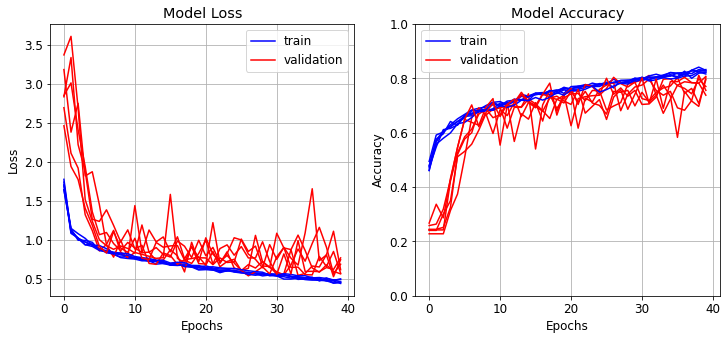

In [139]:
# Model 5 k-fold validation
k = 6 # number of folds
alfa = 0.001 # learning rate
Lambda = 0 # regularizer
epochs = 40
batch_size = 32
acc5, loss5, model5 = k_fold_validation(x_train, y_train, 'model_5', k, alfa, Lambda, epochs, batch_size)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Epoch 1/40
88/88 [==============================] - 11s 127ms/step - loss: 1.9302 - categorical_accuracy: 0.4358 - val_loss: 2.4631 - val_categorical_accuracy: 0.2446
Epoch 2/40
88/88 [==============================] - 10s 119ms/step - loss: 1.2674 - categorical_accuracy: 0.5222 - val_loss: 1.9549 - val_categorical_accuracy: 0.2446
Epoch 3/40
88/88 [==============================] - 10s 118ms/step - loss: 1.1051 - categorical_accuracy: 0.5599 - val_loss: 2.2134 - val_categorical_accuracy: 0.2643
Epoch 4/40
88/88 [==============================] - 11s 121ms/step - loss: 1.0729 - categorical_accuracy: 0.5955 - val_loss: 1.6413 - val_categorical_accuracy: 0.2768
Epoch 5/40
88/88 [==============================] - 11s 120ms/step - loss: 0.9933 - categorical_accuracy: 0.6272 - val_loss: 1.6012 - val_categorical_accuracy: 0.3500
Epoch 6/40
88/88 [=====

88/88 [==============================] - 11s 120ms/step - loss: 0.7493 - categorical_accuracy: 0.7199 - val_loss: 0.8262 - val_categorical_accuracy: 0.7041
Epoch 17/40
88/88 [==============================] - 11s 121ms/step - loss: 0.7166 - categorical_accuracy: 0.7317 - val_loss: 0.8200 - val_categorical_accuracy: 0.7077
Epoch 18/40
88/88 [==============================] - 10s 119ms/step - loss: 0.7239 - categorical_accuracy: 0.7306 - val_loss: 1.0783 - val_categorical_accuracy: 0.6257
Epoch 19/40
88/88 [==============================] - 10s 119ms/step - loss: 0.7067 - categorical_accuracy: 0.7246 - val_loss: 0.7561 - val_categorical_accuracy: 0.7077
Epoch 20/40
88/88 [==============================] - 11s 120ms/step - loss: 0.7020 - categorical_accuracy: 0.7409 - val_loss: 0.7521 - val_categorical_accuracy: 0.7237
Epoch 21/40
88/88 [==============================] - 10s 119ms/step - loss: 0.6760 - categorical_accuracy: 0.7356 - val_loss: 0.7852 - val_categorical_accuracy: 0.7041
Epoc

88/88 [==============================] - 11s 121ms/step - loss: 0.5456 - categorical_accuracy: 0.7961 - val_loss: 0.6089 - val_categorical_accuracy: 0.7807
Epoch 33/40
88/88 [==============================] - 11s 119ms/step - loss: 0.5029 - categorical_accuracy: 0.8075 - val_loss: 0.7910 - val_categorical_accuracy: 0.7540
Epoch 34/40
88/88 [==============================] - 11s 120ms/step - loss: 0.5158 - categorical_accuracy: 0.8082 - val_loss: 0.5836 - val_categorical_accuracy: 0.7914
Epoch 35/40
88/88 [==============================] - 11s 123ms/step - loss: 0.5091 - categorical_accuracy: 0.8071 - val_loss: 0.6260 - val_categorical_accuracy: 0.7736
Epoch 36/40
88/88 [==============================] - 10s 119ms/step - loss: 0.4906 - categorical_accuracy: 0.8135 - val_loss: 0.6704 - val_categorical_accuracy: 0.7701
Epoch 37/40
88/88 [==============================] - 10s 119ms/step - loss: 0.4959 - categorical_accuracy: 0.8167 - val_loss: 0.6538 - val_categorical_accuracy: 0.7879
Epoc

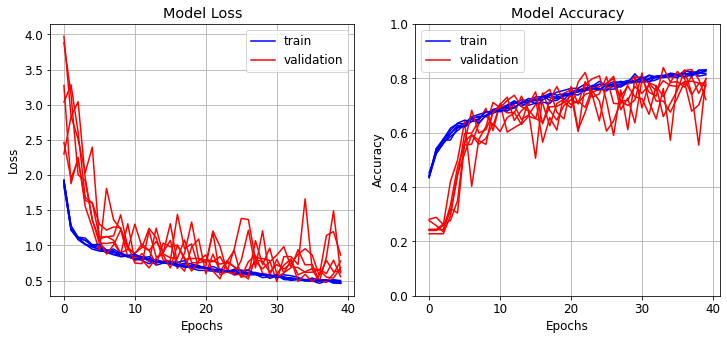

In [140]:
# Model 6 k-fold validation
k = 6 # number of folds
alfa = 0.001 # learning rate
Lambda = 0 # regularizer
epochs = 40
batch_size = 32
acc6, loss6, model6 = k_fold_validation(x_train, y_train, 'model_6', k, alfa, Lambda, epochs, batch_size)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Epoch 1/40
88/88 [==============================] - 12s 132ms/step - loss: 1.7077 - categorical_accuracy: 0.4084 - val_loss: 4.0719 - val_categorical_accuracy: 0.2446
Epoch 2/40
88/88 [==============================] - 11s 120ms/step - loss: 1.3475 - categorical_accuracy: 0.5027 - val_loss: 3.0182 - val_categorical_accuracy: 0.2446
Epoch 3/40
88/88 [==============================] - 10s 119ms/step - loss: 1.2467 - categorical_accuracy: 0.5183 - val_loss: 4.3456 - val_categorical_accuracy: 0.2446
Epoch 4/40
88/88 [==============================] - 11s 121ms/step - loss: 1.1453 - categorical_accuracy: 0.5646 - val_loss: 1.7725 - val_categorical_accuracy: 0.3625
Epoch 5/40
88/88 [==============================] - 11s 121ms/step - loss: 1.0722 - categorical_accuracy: 0.5884 - val_loss: 2.9264 - val_categorical_accuracy: 0.2500
Epoch 6/40
88/88 [=====

88/88 [==============================] - 11s 120ms/step - loss: 0.7793 - categorical_accuracy: 0.7103 - val_loss: 1.1614 - val_categorical_accuracy: 0.6364
Epoch 17/40
88/88 [==============================] - 11s 121ms/step - loss: 0.7492 - categorical_accuracy: 0.7160 - val_loss: 0.8474 - val_categorical_accuracy: 0.6988
Epoch 18/40
88/88 [==============================] - 11s 121ms/step - loss: 0.7384 - categorical_accuracy: 0.7128 - val_loss: 0.9980 - val_categorical_accuracy: 0.6471
Epoch 19/40
88/88 [==============================] - 11s 120ms/step - loss: 0.7523 - categorical_accuracy: 0.7217 - val_loss: 0.9701 - val_categorical_accuracy: 0.6684
Epoch 20/40
88/88 [==============================] - 11s 127ms/step - loss: 0.7311 - categorical_accuracy: 0.7292 - val_loss: 0.7581 - val_categorical_accuracy: 0.7005
Epoch 21/40
88/88 [==============================] - 11s 124ms/step - loss: 0.7548 - categorical_accuracy: 0.7125 - val_loss: 0.8859 - val_categorical_accuracy: 0.6649
Epoc

88/88 [==============================] - 11s 122ms/step - loss: 0.6282 - categorical_accuracy: 0.7644 - val_loss: 0.6845 - val_categorical_accuracy: 0.7504
Epoch 33/40
88/88 [==============================] - 11s 120ms/step - loss: 0.5854 - categorical_accuracy: 0.7847 - val_loss: 0.5447 - val_categorical_accuracy: 0.7736
Epoch 34/40
88/88 [==============================] - 11s 125ms/step - loss: 0.6045 - categorical_accuracy: 0.7758 - val_loss: 0.5830 - val_categorical_accuracy: 0.7914
Epoch 35/40
88/88 [==============================] - 11s 128ms/step - loss: 0.5809 - categorical_accuracy: 0.7779 - val_loss: 0.5533 - val_categorical_accuracy: 0.7986
Epoch 36/40
88/88 [==============================] - 11s 121ms/step - loss: 0.5569 - categorical_accuracy: 0.7968 - val_loss: 0.8019 - val_categorical_accuracy: 0.7255
Epoch 37/40
88/88 [==============================] - 11s 120ms/step - loss: 0.5823 - categorical_accuracy: 0.7929 - val_loss: 0.7494 - val_categorical_accuracy: 0.7576
Epoc

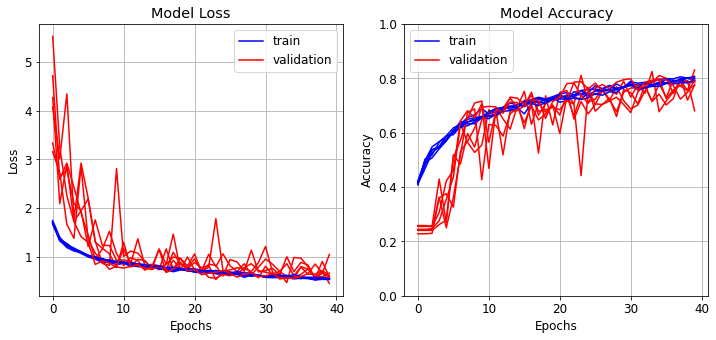

In [141]:
# Model 7 k-fold validation
k = 6 # number of folds
alfa = 0.001 # learning rate
Lambda = 0 # regularizer
epochs = 40
batch_size = 32
acc7, loss7, model7 = k_fold_validation(x_train, y_train, 'model_7', k, alfa, Lambda, epochs, batch_size)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Epoch 1/40
88/88 [==============================] - 12s 138ms/step - loss: 1.1562 - categorical_accuracy: 0.5493 - val_loss: 0.8037 - val_categorical_accuracy: 0.6804
Epoch 2/40
88/88 [==============================] - 11s 124ms/step - loss: 0.7780 - categorical_accuracy: 0.7172 - val_loss: 0.6795 - val_categorical_accuracy: 0.7571
Epoch 3/40
88/88 [==============================] - 11s 122ms/step - loss: 0.6870 - categorical_accuracy: 0.7545 - val_loss: 0.6224 - val_categorical_accuracy: 0.7875
Epoch 4/40
88/88 [==============================] - 11s 123ms/step - loss: 0.6330 - categorical_accuracy: 0.7705 - val_loss: 0.5823 - val_categorical_accuracy: 0.7946
Epoch 5/40
88/88 [==============================] - 11s 122ms/step - loss: 0.6080 - categorical_accuracy: 0.7787 - val_loss: 0.5665 - val_categorical_accuracy: 0.7839
Epoch 6/40
88/88 [=====

88/88 [==============================] - 11s 122ms/step - loss: 0.4726 - categorical_accuracy: 0.8274 - val_loss: 0.5089 - val_categorical_accuracy: 0.8271
Epoch 17/40
88/88 [==============================] - 11s 123ms/step - loss: 0.4760 - categorical_accuracy: 0.8228 - val_loss: 0.4720 - val_categorical_accuracy: 0.8342
Epoch 18/40
88/88 [==============================] - 11s 122ms/step - loss: 0.4546 - categorical_accuracy: 0.8331 - val_loss: 0.4720 - val_categorical_accuracy: 0.8378
Epoch 19/40
88/88 [==============================] - 11s 122ms/step - loss: 0.4511 - categorical_accuracy: 0.8374 - val_loss: 0.4783 - val_categorical_accuracy: 0.8235
Epoch 20/40
88/88 [==============================] - 11s 125ms/step - loss: 0.4480 - categorical_accuracy: 0.8384 - val_loss: 0.4891 - val_categorical_accuracy: 0.8235
Epoch 21/40
88/88 [==============================] - 11s 121ms/step - loss: 0.4409 - categorical_accuracy: 0.8363 - val_loss: 0.4605 - val_categorical_accuracy: 0.8449
Epoc

88/88 [==============================] - 11s 123ms/step - loss: 0.4051 - categorical_accuracy: 0.8498 - val_loss: 0.4882 - val_categorical_accuracy: 0.8253
Epoch 33/40
88/88 [==============================] - 11s 122ms/step - loss: 0.4044 - categorical_accuracy: 0.8516 - val_loss: 0.4788 - val_categorical_accuracy: 0.8289
Epoch 34/40
88/88 [==============================] - 11s 123ms/step - loss: 0.3910 - categorical_accuracy: 0.8584 - val_loss: 0.4690 - val_categorical_accuracy: 0.8414
Epoch 35/40
88/88 [==============================] - 11s 123ms/step - loss: 0.3930 - categorical_accuracy: 0.8516 - val_loss: 0.4784 - val_categorical_accuracy: 0.8378
Epoch 36/40
88/88 [==============================] - 11s 123ms/step - loss: 0.4017 - categorical_accuracy: 0.8523 - val_loss: 0.4863 - val_categorical_accuracy: 0.8414
Epoch 37/40
88/88 [==============================] - 11s 123ms/step - loss: 0.3878 - categorical_accuracy: 0.8616 - val_loss: 0.4989 - val_categorical_accuracy: 0.8146
Epoc

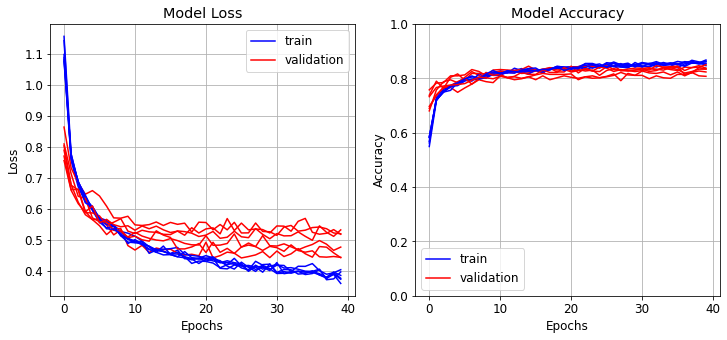

In [142]:
# Model VGG k-fold validation
k = 6 # number of folds
alfa = 0.001 # learning rate
Lambda = 0 # regularizer
epochs = 40
batch_size = 32
acc8, loss8, model8 = k_fold_validation(x_train, y_train, 'model_VGG', k, alfa, Lambda, epochs, batch_size)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Epoch 1/40
88/88 [==============================] - 12s 138ms/step - loss: 1.1109 - categorical_accuracy: 0.6457 - val_loss: 0.6214 - val_categorical_accuracy: 0.7554
Epoch 2/40
88/88 [==============================] - 11s 124ms/step - loss: 0.6501 - categorical_accuracy: 0.7602 - val_loss: 0.5520 - val_categorical_accuracy: 0.7875
Epoch 3/40
88/88 [==============================] - 11s 122ms/step - loss: 0.6150 - categorical_accuracy: 0.7698 - val_loss: 0.5355 - val_categorical_accuracy: 0.8107
Epoch 4/40
88/88 [==============================] - 11s 125ms/step - loss: 0.5577 - categorical_accuracy: 0.7880 - val_loss: 0.5272 - val_categorical_accuracy: 0.7964
Epoch 5/40
88/88 [==============================] - 11s 127ms/step - loss: 0.5150 - categorical_accuracy: 0.8058 - val_loss: 0.5769 - val_categorical_accuracy: 0.7893
Epoch 6/40
88/88 [=====

88/88 [==============================] - 11s 124ms/step - loss: 0.3573 - categorical_accuracy: 0.8683 - val_loss: 0.4082 - val_categorical_accuracy: 0.8503
Epoch 17/40
88/88 [==============================] - 11s 126ms/step - loss: 0.3646 - categorical_accuracy: 0.8580 - val_loss: 0.4735 - val_categorical_accuracy: 0.8467
Epoch 18/40
88/88 [==============================] - 11s 123ms/step - loss: 0.3605 - categorical_accuracy: 0.8655 - val_loss: 0.4697 - val_categorical_accuracy: 0.8378
Epoch 19/40
88/88 [==============================] - 11s 124ms/step - loss: 0.3413 - categorical_accuracy: 0.8715 - val_loss: 0.4273 - val_categorical_accuracy: 0.8449
Epoch 20/40
88/88 [==============================] - 11s 124ms/step - loss: 0.3148 - categorical_accuracy: 0.8847 - val_loss: 0.4520 - val_categorical_accuracy: 0.8235
Epoch 21/40
88/88 [==============================] - 11s 123ms/step - loss: 0.3000 - categorical_accuracy: 0.8904 - val_loss: 0.4486 - val_categorical_accuracy: 0.8414
Epoc

88/88 [==============================] - 11s 123ms/step - loss: 0.2327 - categorical_accuracy: 0.9164 - val_loss: 0.5598 - val_categorical_accuracy: 0.8396
Epoch 33/40
88/88 [==============================] - 11s 122ms/step - loss: 0.2278 - categorical_accuracy: 0.9121 - val_loss: 0.4883 - val_categorical_accuracy: 0.8396
Epoch 34/40
88/88 [==============================] - 11s 124ms/step - loss: 0.2264 - categorical_accuracy: 0.9153 - val_loss: 0.5298 - val_categorical_accuracy: 0.8307
Epoch 35/40
88/88 [==============================] - 11s 123ms/step - loss: 0.2137 - categorical_accuracy: 0.9217 - val_loss: 0.5111 - val_categorical_accuracy: 0.8538
Epoch 36/40
88/88 [==============================] - 11s 122ms/step - loss: 0.2401 - categorical_accuracy: 0.9089 - val_loss: 0.4681 - val_categorical_accuracy: 0.8396
Epoch 37/40
88/88 [==============================] - 11s 125ms/step - loss: 0.2166 - categorical_accuracy: 0.9164 - val_loss: 0.4832 - val_categorical_accuracy: 0.8414
Epoc

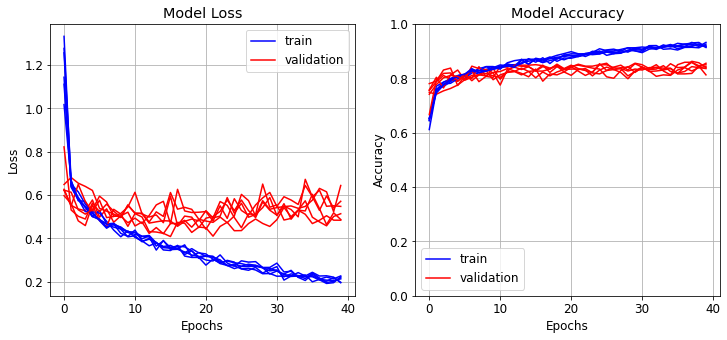

In [143]:
# Model VGG2 k-fold validation
k = 6 # number of folds
alfa = 0.001 # learning rate
Lambda = 0 # regularizer
epochs = 40
batch_size = 32
acc9, loss9, model9 = k_fold_validation(x_train, y_train, 'model_VGG2', k, alfa, Lambda, epochs, batch_size)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Model: "FlowerModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 2, 2, 512)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              8392704   
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)    

Epoch 40/40
88/88 [==============================] - 12s 133ms/step - loss: 0.2936 - categorical_accuracy: 0.8940 - val_loss: 0.5863 - val_categorical_accuracy: 0.8057
------------------------------------------------------------------------
[INFO] Training for fold no 2
Model: "FlowerModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 2, 2, 512)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 4096)       

Epoch 40/40
88/88 [==============================] - 13s 146ms/step - loss: 0.2800 - categorical_accuracy: 0.8950 - val_loss: 0.4540 - val_categorical_accuracy: 0.8592
------------------------------------------------------------------------
[INFO] Training for fold no 3
Model: "FlowerModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 2, 2, 512)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 4096)       

Epoch 40/40
88/88 [==============================] - 12s 132ms/step - loss: 0.2898 - categorical_accuracy: 0.8915 - val_loss: 0.5002 - val_categorical_accuracy: 0.8324
------------------------------------------------------------------------
[INFO] Training for fold no 4
Model: "FlowerModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 2, 2, 512)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 4096)       

Epoch 40/40
88/88 [==============================] - 12s 132ms/step - loss: 0.3142 - categorical_accuracy: 0.8797 - val_loss: 0.4490 - val_categorical_accuracy: 0.8485
------------------------------------------------------------------------
[INFO] Training for fold no 5
Model: "FlowerModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 2, 2, 512)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 4096)       

Epoch 40/40
88/88 [==============================] - 12s 139ms/step - loss: 0.2831 - categorical_accuracy: 0.8893 - val_loss: 0.6386 - val_categorical_accuracy: 0.8182
------------------------------------------------------------------------
[INFO] Average scores for all folds: loss - 0.5132192974915358; accuracy - 83.32845270633698%


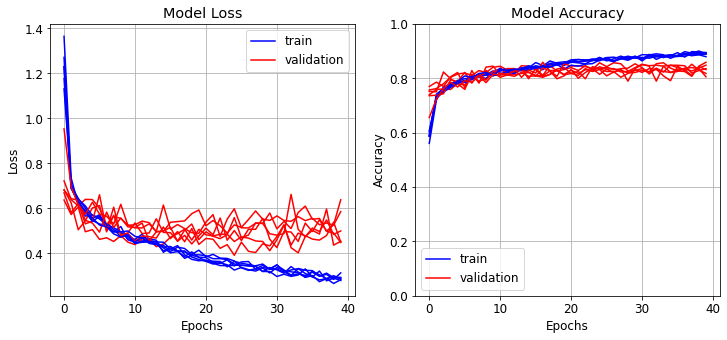

In [57]:
# Model VGG3 k-fold validation
k = 6 # number of folds
alfa = 0.001 # learning rate
Lambda = 0 # regularizer
epochs = 40
batch_size = 32
acc10, loss10, model10 = k_fold_validation(x_train, y_train, 'model_VGG3', k, alfa, Lambda, epochs, batch_size)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Model: "FlowerModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_58 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 2, 2, 512)         0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)     

Epoch 40/40
88/88 [==============================] - 11s 125ms/step - loss: 0.4632 - categorical_accuracy: 0.8349 - val_loss: 0.4333 - val_categorical_accuracy: 0.8429
------------------------------------------------------------------------
[INFO] Training for fold no 1
Model: "FlowerModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 2, 2, 512)         0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 512)        

Epoch 39/40
88/88 [==============================] - 11s 123ms/step - loss: 0.4802 - categorical_accuracy: 0.8231 - val_loss: 0.4999 - val_categorical_accuracy: 0.8431
Epoch 40/40
88/88 [==============================] - 11s 121ms/step - loss: 0.4636 - categorical_accuracy: 0.8206 - val_loss: 0.5297 - val_categorical_accuracy: 0.8200
------------------------------------------------------------------------
[INFO] Training for fold no 2
Model: "FlowerModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_62 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 2, 2, 512)         0         
_________________________________________________________________
flatten_31 (

Epoch 38/40
88/88 [==============================] - 11s 131ms/step - loss: 0.4658 - categorical_accuracy: 0.8253 - val_loss: 0.4397 - val_categorical_accuracy: 0.8414
Epoch 39/40
88/88 [==============================] - 13s 143ms/step - loss: 0.4667 - categorical_accuracy: 0.8206 - val_loss: 0.4861 - val_categorical_accuracy: 0.8093
Epoch 40/40
88/88 [==============================] - 11s 128ms/step - loss: 0.4519 - categorical_accuracy: 0.8370 - val_loss: 0.4614 - val_categorical_accuracy: 0.8378
------------------------------------------------------------------------
[INFO] Training for fold no 3
Model: "FlowerModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_64 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 4, 4, 512)         14714688  
__________________________________________

Epoch 37/40
88/88 [==============================] - 11s 126ms/step - loss: 0.4720 - categorical_accuracy: 0.8270 - val_loss: 0.4848 - val_categorical_accuracy: 0.7986
Epoch 38/40
88/88 [==============================] - 11s 120ms/step - loss: 0.4794 - categorical_accuracy: 0.8185 - val_loss: 0.4643 - val_categorical_accuracy: 0.8164
Epoch 39/40
88/88 [==============================] - 11s 120ms/step - loss: 0.4614 - categorical_accuracy: 0.8235 - val_loss: 0.4472 - val_categorical_accuracy: 0.8307
Epoch 40/40
88/88 [==============================] - 13s 143ms/step - loss: 0.4683 - categorical_accuracy: 0.8249 - val_loss: 0.4431 - val_categorical_accuracy: 0.8431
------------------------------------------------------------------------
[INFO] Training for fold no 4
Model: "FlowerModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_66 (InputLayer)        (None, 150, 150, 3)       0         
______

Epoch 36/40
88/88 [==============================] - 11s 120ms/step - loss: 0.4819 - categorical_accuracy: 0.8128 - val_loss: 0.4735 - val_categorical_accuracy: 0.8271
Epoch 37/40
88/88 [==============================] - 11s 119ms/step - loss: 0.4790 - categorical_accuracy: 0.8299 - val_loss: 0.4762 - val_categorical_accuracy: 0.8324
Epoch 38/40
88/88 [==============================] - 11s 122ms/step - loss: 0.4607 - categorical_accuracy: 0.8352 - val_loss: 0.4634 - val_categorical_accuracy: 0.8324
Epoch 39/40
88/88 [==============================] - 11s 123ms/step - loss: 0.4777 - categorical_accuracy: 0.8189 - val_loss: 0.4813 - val_categorical_accuracy: 0.8146
Epoch 40/40
88/88 [==============================] - 11s 120ms/step - loss: 0.4783 - categorical_accuracy: 0.8235 - val_loss: 0.4675 - val_categorical_accuracy: 0.8378
------------------------------------------------------------------------
[INFO] Training for fold no 5
Model: "FlowerModel"
____________________________________

Epoch 35/40
88/88 [==============================] - 12s 138ms/step - loss: 0.4850 - categorical_accuracy: 0.8206 - val_loss: 0.4886 - val_categorical_accuracy: 0.8004
Epoch 36/40
88/88 [==============================] - 11s 128ms/step - loss: 0.4663 - categorical_accuracy: 0.8295 - val_loss: 0.5468 - val_categorical_accuracy: 0.8075
Epoch 37/40
88/88 [==============================] - 11s 120ms/step - loss: 0.4959 - categorical_accuracy: 0.8199 - val_loss: 0.5332 - val_categorical_accuracy: 0.8004
Epoch 38/40
88/88 [==============================] - 11s 123ms/step - loss: 0.4841 - categorical_accuracy: 0.8160 - val_loss: 0.5160 - val_categorical_accuracy: 0.8200
Epoch 39/40
88/88 [==============================] - 11s 123ms/step - loss: 0.4632 - categorical_accuracy: 0.8342 - val_loss: 0.5128 - val_categorical_accuracy: 0.8146
Epoch 40/40
88/88 [==============================] - 11s 122ms/step - loss: 0.4762 - categorical_accuracy: 0.8160 - val_loss: 0.4902 - val_categorical_accuracy:

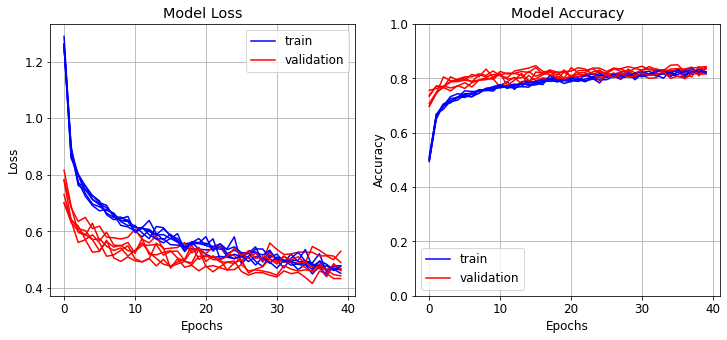

In [35]:
# Model VGG4 k-fold validation
k = 6 # number of folds
alfa = 0.001 # learning rate
Lambda = 0 # regularizer
epochs = 40
batch_size = 32
acc10, loss10, model10 = k_fold_validation(x_train, y_train, 'model_VGG4', k, alfa, Lambda, epochs, batch_size)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Epoch 1/40
88/88 [==============================] - 13s 153ms/step - loss: 1.1955 - categorical_accuracy: 0.5845 - val_loss: 1.2909 - val_categorical_accuracy: 0.6018
Epoch 2/40
88/88 [==============================] - 11s 126ms/step - loss: 0.9387 - categorical_accuracy: 0.6795 - val_loss: 0.7790 - val_categorical_accuracy: 0.7607
Epoch 3/40
88/88 [==============================] - 11s 130ms/step - loss: 0.9376 - categorical_accuracy: 0.6916 - val_loss: 0.9115 - val_categorical_accuracy: 0.7107
Epoch 4/40
88/88 [==============================] - 11s 125ms/step - loss: 0.9398 - categorical_accuracy: 0.6955 - val_loss: 0.7482 - val_categorical_accuracy: 0.7518
Epoch 5/40
88/88 [==============================] - 11s 127ms/step - loss: 0.8513 - categorical_accuracy: 0.7360 - val_loss: 0.9657 - val_categorical_accuracy: 0.7107
Epoch 6/40
88/88 [=====

88/88 [==============================] - 12s 132ms/step - loss: 0.8017 - categorical_accuracy: 0.7580 - val_loss: 1.0641 - val_categorical_accuracy: 0.6952
Epoch 17/40
88/88 [==============================] - 11s 128ms/step - loss: 0.7927 - categorical_accuracy: 0.7598 - val_loss: 1.2796 - val_categorical_accuracy: 0.6542
Epoch 18/40
88/88 [==============================] - 11s 128ms/step - loss: 0.8216 - categorical_accuracy: 0.7484 - val_loss: 1.4836 - val_categorical_accuracy: 0.6096
Epoch 19/40
88/88 [==============================] - 11s 126ms/step - loss: 0.8514 - categorical_accuracy: 0.7456 - val_loss: 1.1510 - val_categorical_accuracy: 0.6881
Epoch 20/40
88/88 [==============================] - 11s 131ms/step - loss: 0.9080 - categorical_accuracy: 0.7466 - val_loss: 1.3433 - val_categorical_accuracy: 0.6346
Epoch 21/40
88/88 [==============================] - 11s 129ms/step - loss: 0.8870 - categorical_accuracy: 0.7505 - val_loss: 1.5238 - val_categorical_accuracy: 0.6168
Epoc

88/88 [==============================] - 11s 126ms/step - loss: 0.7887 - categorical_accuracy: 0.7754 - val_loss: 1.5084 - val_categorical_accuracy: 0.6417
Epoch 33/40
88/88 [==============================] - 11s 130ms/step - loss: 0.8740 - categorical_accuracy: 0.7509 - val_loss: 1.6584 - val_categorical_accuracy: 0.6381
Epoch 34/40
88/88 [==============================] - 11s 127ms/step - loss: 0.7534 - categorical_accuracy: 0.7701 - val_loss: 1.3540 - val_categorical_accuracy: 0.6934
Epoch 35/40
88/88 [==============================] - 11s 127ms/step - loss: 0.8497 - categorical_accuracy: 0.7612 - val_loss: 1.4454 - val_categorical_accuracy: 0.6916
Epoch 36/40
88/88 [==============================] - 11s 130ms/step - loss: 0.7562 - categorical_accuracy: 0.7790 - val_loss: 1.3367 - val_categorical_accuracy: 0.6863
Epoch 37/40
88/88 [==============================] - 11s 126ms/step - loss: 0.8007 - categorical_accuracy: 0.7619 - val_loss: 1.4032 - val_categorical_accuracy: 0.6988
Epoc

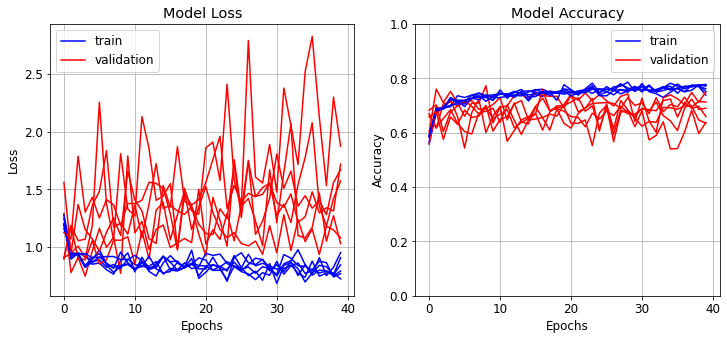

In [78]:
# Model Xception k-fold validation
k = 6 # number of folds
alfa = 0.001 # learning rate
Lambda = 0 # regularizer
epochs = 40
batch_size = 32
acc11, loss11, model11 = k_fold_validation(x_train, y_train, 'model_Xception', k, alfa, Lambda, epochs, batch_size)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Train on 2811 samples, validate on 560 samples
Epoch 1/40
2811/2811 [==============================] - 14s 5ms/step - loss: 1.3701 - categorical_accuracy: 0.4596 - val_loss: 1.2131 - val_categorical_accuracy: 0.4857
Epoch 2/40
2811/2811 [==============================] - 10s 4ms/step - loss: 1.0258 - categorical_accuracy: 0.6403 - val_loss: 1.0750 - val_categorical_accuracy: 0.5554
Epoch 3/40
2811/2811 [==============================] - 10s 4ms/step - loss: 0.8936 - categorical_accuracy: 0.7026 - val_loss: 0.9828 - val_categorical_accuracy: 0.6143
Epoch 4/40
2811/2811 [==============================] - 10s 4ms/step - loss: 0.8122 - categorical_accuracy: 0.7353 - val_loss: 0.8747 - val_categorical_accuracy: 0.6750
Epoch 5/40
2811/2811 [==============================] - 10s 4ms/step - loss: 0.7426 - categorical_accuracy: 0.7617 - val_loss: 0.8856 -

Epoch 7/40
2810/2810 [==============================] - 10s 4ms/step - loss: 0.6609 - categorical_accuracy: 0.7883 - val_loss: 0.9439 - val_categorical_accuracy: 0.6239
Epoch 8/40
2810/2810 [==============================] - 11s 4ms/step - loss: 0.6277 - categorical_accuracy: 0.7979 - val_loss: 0.9594 - val_categorical_accuracy: 0.6168
Epoch 9/40
2810/2810 [==============================] - 10s 4ms/step - loss: 0.6078 - categorical_accuracy: 0.7972 - val_loss: 0.9862 - val_categorical_accuracy: 0.6185
Epoch 10/40
2810/2810 [==============================] - 10s 4ms/step - loss: 0.5928 - categorical_accuracy: 0.8032 - val_loss: 1.0201 - val_categorical_accuracy: 0.6061
Epoch 11/40
2810/2810 [==============================] - 10s 4ms/step - loss: 0.5656 - categorical_accuracy: 0.8089 - val_loss: 0.9658 - val_categorical_accuracy: 0.6203
Epoch 12/40
2810/2810 [==============================] - 10s 4ms/step - loss: 0.5580 - categorical_accuracy: 0.8206 - val_loss: 0.9343 - val_categorical_

2810/2810 [==============================] - 10s 4ms/step - loss: 0.4574 - categorical_accuracy: 0.8512 - val_loss: 0.8802 - val_categorical_accuracy: 0.6702
Epoch 21/40
2810/2810 [==============================] - 10s 4ms/step - loss: 0.4347 - categorical_accuracy: 0.8609 - val_loss: 0.8426 - val_categorical_accuracy: 0.6970
Epoch 22/40
2810/2810 [==============================] - 11s 4ms/step - loss: 0.4264 - categorical_accuracy: 0.8644 - val_loss: 0.9073 - val_categorical_accuracy: 0.6667
Epoch 23/40
2810/2810 [==============================] - 11s 4ms/step - loss: 0.4112 - categorical_accuracy: 0.8698 - val_loss: 0.9363 - val_categorical_accuracy: 0.6471s - loss: 0.4099 - cate
Epoch 24/40
2810/2810 [==============================] - 10s 4ms/step - loss: 0.4049 - categorical_accuracy: 0.8747 - val_loss: 0.8637 - val_categorical_accuracy: 0.6791
Epoch 25/40
2810/2810 [==============================] - 10s 4ms/step - loss: 0.3929 - categorical_accuracy: 0.8790 - val_loss: 0.8952 - va

2810/2810 [==============================] - 10s 4ms/step - loss: 0.3614 - categorical_accuracy: 0.8918 - val_loss: 0.9694 - val_categorical_accuracy: 0.6649
Epoch 32/40
2810/2810 [==============================] - 10s 4ms/step - loss: 0.3452 - categorical_accuracy: 0.8968 - val_loss: 1.0212 - val_categorical_accuracy: 0.6595
Epoch 33/40
2810/2810 [==============================] - 10s 4ms/step - loss: 0.3383 - categorical_accuracy: 0.9078 - val_loss: 0.9126 - val_categorical_accuracy: 0.6952
Epoch 34/40
2810/2810 [==============================] - 10s 4ms/step - loss: 0.3341 - categorical_accuracy: 0.9028 - val_loss: 0.9565 - val_categorical_accuracy: 0.6738
Epoch 35/40
2810/2810 [==============================] - 10s 4ms/step - loss: 0.3368 - categorical_accuracy: 0.9050 - val_loss: 0.9886 - val_categorical_accuracy: 0.6756
Epoch 36/40
2810/2810 [==============================] - 11s 4ms/step - loss: 0.3286 - categorical_accuracy: 0.8982 - val_loss: 1.0094 - val_categorical_accuracy:

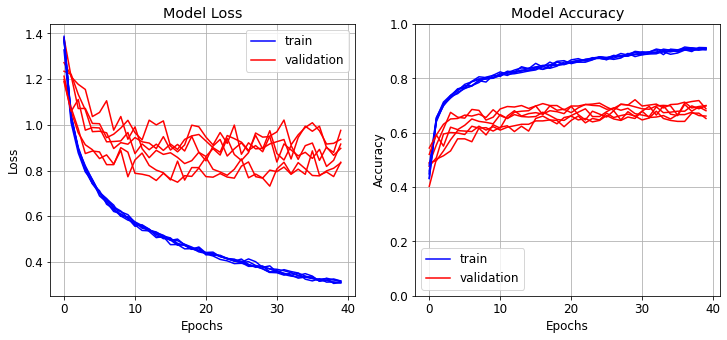

In [31]:
# Model Xception2 k-fold validation
k = 6 # number of folds
alfa = 0.001 # learning rate
Lambda = 0 # regularizer
epochs = 40
batch_size = 32
acc11, loss11, model11 = k_fold_validation(x_train, y_train, 'model_Xception2', k, alfa, Lambda, epochs, batch_size)

## Different learning rates (0.01, 0.001, 0.0001) - Model VGG2

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Epoch 1/50
88/88 [==============================] - 17s 195ms/step - loss: 0.9370 - categorical_accuracy: 0.6471 - val_loss: 0.6439 - val_categorical_accuracy: 0.7875
Epoch 2/50
88/88 [==============================] - 11s 120ms/step - loss: 0.6637 - categorical_accuracy: 0.7446 - val_loss: 0.5830 - val_categorical_accuracy: 0.7911
Epoch 3/50
88/88 [==============================] - 11s 123ms/step - loss: 0.5869 - categorical_accuracy: 0.7837 - val_loss: 0.5084 - val_categorical_accuracy: 0.8089
Epoch 4/50
88/88 [==============================] - 10s 118ms/step - loss: 0.5328 - categorical_accuracy: 0.7990 - val_loss: 0.4817 - val_categorical_accuracy: 0.8232
Epoch 5/50
88/88 [==============================] - 10s 119ms/step - loss: 0.5149 - categorical_accuracy: 0.8150 - val_loss: 0.4851 - val_categorical_accuracy: 0.8179
Epoch 6/50
88/88 [=====

Epoch 49/50
88/88 [==============================] - 10s 119ms/step - loss: 0.2047 - categorical_accuracy: 0.9264 - val_loss: 0.4331 - val_categorical_accuracy: 0.8500
Epoch 50/50
88/88 [==============================] - 10s 119ms/step - loss: 0.2031 - categorical_accuracy: 0.9271 - val_loss: 0.4603 - val_categorical_accuracy: 0.8339
------------------------------------------------------------------------
[INFO] Training for fold no 1
Epoch 1/50
88/88 [==============================] - 13s 153ms/step - loss: 0.8919 - categorical_accuracy: 0.6626 - val_loss: 0.6989 - val_categorical_accuracy: 0.7522
Epoch 2/50
88/88 [==============================] - 10s 119ms/step - loss: 0.6179 - categorical_accuracy: 0.7801 - val_loss: 0.6120 - val_categorical_accuracy: 0.7754
Epoch 3/50
88/88 [==============================] - 10s 119ms/step - loss: 0.5921 - categorical_accuracy: 0.7811 - val_loss: 0.5883 - val_categorical_accuracy: 0.7897
Epoch 4/50
88/88 [==============================] - 11s 120m

88/88 [==============================] - 11s 120ms/step - loss: 0.2206 - categorical_accuracy: 0.9246 - val_loss: 0.4255 - val_categorical_accuracy: 0.8520
Epoch 46/50
88/88 [==============================] - 10s 119ms/step - loss: 0.2134 - categorical_accuracy: 0.9278 - val_loss: 0.3992 - val_categorical_accuracy: 0.8520
Epoch 47/50
88/88 [==============================] - 11s 121ms/step - loss: 0.2043 - categorical_accuracy: 0.9278 - val_loss: 0.4099 - val_categorical_accuracy: 0.8520
Epoch 48/50
88/88 [==============================] - 11s 121ms/step - loss: 0.1997 - categorical_accuracy: 0.9263 - val_loss: 0.4457 - val_categorical_accuracy: 0.8360
Epoch 49/50
88/88 [==============================] - 11s 121ms/step - loss: 0.2027 - categorical_accuracy: 0.9238 - val_loss: 0.4119 - val_categorical_accuracy: 0.8610
Epoch 50/50
88/88 [==============================] - 11s 121ms/step - loss: 0.2029 - categorical_accuracy: 0.9249 - val_loss: 0.4571 - val_categorical_accuracy: 0.8574
----

88/88 [==============================] - 11s 120ms/step - loss: 0.2101 - categorical_accuracy: 0.9260 - val_loss: 0.4470 - val_categorical_accuracy: 0.8485
Epoch 42/50
88/88 [==============================] - 10s 119ms/step - loss: 0.2185 - categorical_accuracy: 0.9242 - val_loss: 0.4417 - val_categorical_accuracy: 0.8503
Epoch 43/50
88/88 [==============================] - 11s 120ms/step - loss: 0.2388 - categorical_accuracy: 0.9167 - val_loss: 0.4626 - val_categorical_accuracy: 0.8538
Epoch 44/50
88/88 [==============================] - 10s 119ms/step - loss: 0.2194 - categorical_accuracy: 0.9196 - val_loss: 0.4602 - val_categorical_accuracy: 0.8503
Epoch 45/50
88/88 [==============================] - 11s 119ms/step - loss: 0.2233 - categorical_accuracy: 0.9281 - val_loss: 0.4438 - val_categorical_accuracy: 0.8503
Epoch 46/50
88/88 [==============================] - 11s 119ms/step - loss: 0.2153 - categorical_accuracy: 0.9189 - val_loss: 0.4273 - val_categorical_accuracy: 0.8449
Epoc

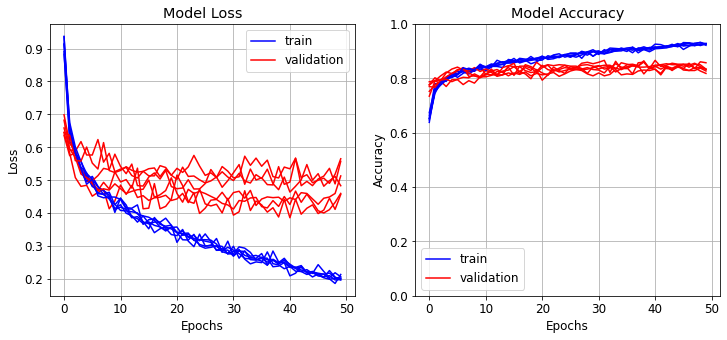

In [25]:
k = 6 # number of folds
alfa = 0.0001 # learning rate
Lambda = 0 # regularizer
epochs = 40
batch_size = 32
acc12, loss12, model12 = k_fold_validation(x_train, y_train, 'model_VGG2', k, alfa, Lambda, epochs, batch_size)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Epoch 1/50
88/88 [==============================] - 12s 139ms/step - loss: 6.4711 - categorical_accuracy: 0.5799 - val_loss: 0.6938 - val_categorical_accuracy: 0.7446
Epoch 2/50
88/88 [==============================] - 10s 118ms/step - loss: 0.7106 - categorical_accuracy: 0.7371 - val_loss: 0.5421 - val_categorical_accuracy: 0.8054
Epoch 3/50
88/88 [==============================] - 10s 118ms/step - loss: 0.6081 - categorical_accuracy: 0.7695 - val_loss: 0.6145 - val_categorical_accuracy: 0.7500
Epoch 4/50
88/88 [==============================] - 10s 119ms/step - loss: 0.5564 - categorical_accuracy: 0.7805 - val_loss: 0.5609 - val_categorical_accuracy: 0.7821
Epoch 5/50
88/88 [==============================] - 11s 121ms/step - loss: 0.5831 - categorical_accuracy: 0.7851 - val_loss: 0.5200 - val_categorical_accuracy: 0.7875
Epoch 6/50
88/88 [=====

Epoch 49/50
88/88 [==============================] - 11s 130ms/step - loss: 0.3323 - categorical_accuracy: 0.8787 - val_loss: 0.5806 - val_categorical_accuracy: 0.8321
Epoch 50/50
88/88 [==============================] - 11s 130ms/step - loss: 0.3334 - categorical_accuracy: 0.8790 - val_loss: 0.5663 - val_categorical_accuracy: 0.8464
------------------------------------------------------------------------
[INFO] Training for fold no 1
Epoch 1/50
88/88 [==============================] - 12s 134ms/step - loss: 5.1405 - categorical_accuracy: 0.6011 - val_loss: 0.7061 - val_categorical_accuracy: 0.7237
Epoch 2/50
88/88 [==============================] - 11s 121ms/step - loss: 0.6707 - categorical_accuracy: 0.7484 - val_loss: 0.7559 - val_categorical_accuracy: 0.7077
Epoch 3/50
88/88 [==============================] - 14s 158ms/step - loss: 0.6267 - categorical_accuracy: 0.7665 - val_loss: 0.6162 - val_categorical_accuracy: 0.7611
Epoch 4/50
88/88 [==============================] - 13s 145m

88/88 [==============================] - 12s 133ms/step - loss: 0.3912 - categorical_accuracy: 0.8559 - val_loss: 0.5912 - val_categorical_accuracy: 0.8235
Epoch 46/50
88/88 [==============================] - 12s 131ms/step - loss: 0.3595 - categorical_accuracy: 0.8715 - val_loss: 0.6079 - val_categorical_accuracy: 0.8235
Epoch 47/50
88/88 [==============================] - 12s 138ms/step - loss: 0.3879 - categorical_accuracy: 0.8630 - val_loss: 0.5024 - val_categorical_accuracy: 0.8235
Epoch 48/50
88/88 [==============================] - 13s 144ms/step - loss: 0.3720 - categorical_accuracy: 0.8623 - val_loss: 0.5681 - val_categorical_accuracy: 0.8253
Epoch 49/50
88/88 [==============================] - 12s 135ms/step - loss: 0.3567 - categorical_accuracy: 0.8740 - val_loss: 0.5331 - val_categorical_accuracy: 0.8271
Epoch 50/50
88/88 [==============================] - 12s 135ms/step - loss: 0.3776 - categorical_accuracy: 0.8633 - val_loss: 0.6917 - val_categorical_accuracy: 0.8039
----

88/88 [==============================] - 12s 132ms/step - loss: 0.3816 - categorical_accuracy: 0.8544 - val_loss: 0.6495 - val_categorical_accuracy: 0.8111
Epoch 42/50
88/88 [==============================] - 12s 135ms/step - loss: 0.4155 - categorical_accuracy: 0.8431 - val_loss: 0.5650 - val_categorical_accuracy: 0.8021
Epoch 43/50
88/88 [==============================] - 13s 148ms/step - loss: 0.3982 - categorical_accuracy: 0.8505 - val_loss: 0.5585 - val_categorical_accuracy: 0.8342
Epoch 44/50
88/88 [==============================] - 12s 138ms/step - loss: 0.3936 - categorical_accuracy: 0.8651 - val_loss: 0.5487 - val_categorical_accuracy: 0.8289
Epoch 45/50
88/88 [==============================] - 13s 143ms/step - loss: 0.4019 - categorical_accuracy: 0.8512 - val_loss: 0.5643 - val_categorical_accuracy: 0.8324
Epoch 46/50
88/88 [==============================] - 13s 143ms/step - loss: 0.3833 - categorical_accuracy: 0.8577 - val_loss: 0.6114 - val_categorical_accuracy: 0.8324
Epoc

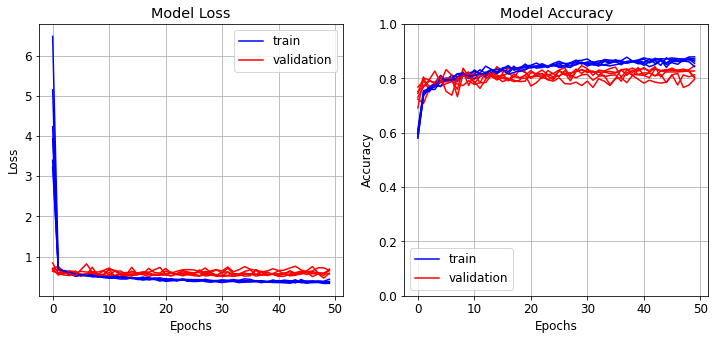

In [27]:
k = 6 # number of folds
alfa = 0.01 # learning rate
Lambda = 0 # regularizer
epochs = 40
batch_size = 32
acc13, loss13, model13 = k_fold_validation(x_train, y_train, 'model_VGG2', k, alfa, Lambda, epochs, batch_size)

## Different batch sizes (16, 32, 64) - Model VGG2

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Epoch 1/50
44/44 [==============================] - 16s 367ms/step - loss: 1.3571 - categorical_accuracy: 0.6137 - val_loss: 0.6227 - val_categorical_accuracy: 0.7589
Epoch 2/50
44/44 [==============================] - 9s 211ms/step - loss: 0.6507 - categorical_accuracy: 0.7567 - val_loss: 0.5123 - val_categorical_accuracy: 0.8250
Epoch 3/50
44/44 [==============================] - 10s 232ms/step - loss: 0.5929 - categorical_accuracy: 0.7766 - val_loss: 0.5169 - val_categorical_accuracy: 0.7946
Epoch 4/50
44/44 [==============================] - 10s 233ms/step - loss: 0.5496 - categorical_accuracy: 0.7858 - val_loss: 0.4653 - val_categorical_accuracy: 0.8214
Epoch 5/50
44/44 [==============================] - 10s 237ms/step - loss: 0.4967 - categorical_accuracy: 0.8157 - val_loss: 0.4847 - val_categorical_accuracy: 0.8107
Epoch 6/50
44/44 [======

Epoch 49/50
44/44 [==============================] - 10s 234ms/step - loss: 0.1583 - categorical_accuracy: 0.9434 - val_loss: 0.5367 - val_categorical_accuracy: 0.8411
Epoch 50/50
44/44 [==============================] - 10s 235ms/step - loss: 0.1833 - categorical_accuracy: 0.9349 - val_loss: 0.5047 - val_categorical_accuracy: 0.8429
------------------------------------------------------------------------
[INFO] Training for fold no 1
Epoch 1/50
44/44 [==============================] - 14s 321ms/step - loss: 1.4714 - categorical_accuracy: 0.5904 - val_loss: 0.7391 - val_categorical_accuracy: 0.7255
Epoch 2/50
44/44 [==============================] - 10s 218ms/step - loss: 0.6519 - categorical_accuracy: 0.7520 - val_loss: 0.6728 - val_categorical_accuracy: 0.7344
Epoch 3/50
44/44 [==============================] - 11s 243ms/step - loss: 0.5941 - categorical_accuracy: 0.7797 - val_loss: 0.5822 - val_categorical_accuracy: 0.7950
Epoch 4/50
44/44 [==============================] - 11s 239m

44/44 [==============================] - 10s 237ms/step - loss: 0.2044 - categorical_accuracy: 0.9178 - val_loss: 0.4563 - val_categorical_accuracy: 0.8342
Epoch 46/50
44/44 [==============================] - 10s 231ms/step - loss: 0.2016 - categorical_accuracy: 0.9235 - val_loss: 0.4855 - val_categorical_accuracy: 0.8396
Epoch 47/50
44/44 [==============================] - 10s 236ms/step - loss: 0.1693 - categorical_accuracy: 0.9345 - val_loss: 0.5066 - val_categorical_accuracy: 0.8663
Epoch 48/50
44/44 [==============================] - 10s 234ms/step - loss: 0.1681 - categorical_accuracy: 0.9370 - val_loss: 0.4982 - val_categorical_accuracy: 0.8538
Epoch 49/50
44/44 [==============================] - 10s 236ms/step - loss: 0.1830 - categorical_accuracy: 0.9317 - val_loss: 0.4891 - val_categorical_accuracy: 0.8431
Epoch 50/50
44/44 [==============================] - 10s 233ms/step - loss: 0.1791 - categorical_accuracy: 0.9359 - val_loss: 0.5510 - val_categorical_accuracy: 0.8182
----

44/44 [==============================] - 10s 234ms/step - loss: 0.2288 - categorical_accuracy: 0.9114 - val_loss: 0.5173 - val_categorical_accuracy: 0.8378
Epoch 42/50
44/44 [==============================] - 10s 232ms/step - loss: 0.2052 - categorical_accuracy: 0.9249 - val_loss: 0.5198 - val_categorical_accuracy: 0.8378
Epoch 43/50
44/44 [==============================] - 10s 234ms/step - loss: 0.1805 - categorical_accuracy: 0.9352 - val_loss: 0.5632 - val_categorical_accuracy: 0.8289
Epoch 44/50
44/44 [==============================] - 10s 234ms/step - loss: 0.2050 - categorical_accuracy: 0.9210 - val_loss: 0.5500 - val_categorical_accuracy: 0.8253
Epoch 45/50
44/44 [==============================] - 11s 239ms/step - loss: 0.2051 - categorical_accuracy: 0.9189 - val_loss: 0.6330 - val_categorical_accuracy: 0.8164
Epoch 46/50
44/44 [==============================] - 11s 245ms/step - loss: 0.1943 - categorical_accuracy: 0.9278 - val_loss: 0.4875 - val_categorical_accuracy: 0.8396
Epoc

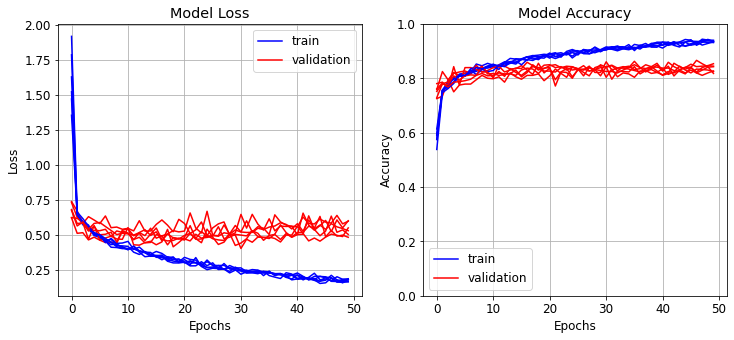

In [28]:
k = 6 # number of folds
alfa = 0.001 # learning rate
Lambda = 0 # regularizer
epochs = 40
batch_size = 64
acc14, loss14, model14 = k_fold_validation(x_train, y_train, 'model_VGG2', k, alfa, Lambda, epochs, batch_size)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Epoch 1/40
176/176 [==============================] - 20s 113ms/step - loss: 1.0522 - categorical_accuracy: 0.6620 - val_loss: 0.6144 - val_categorical_accuracy: 0.7625
Epoch 2/40
176/176 [==============================] - 13s 72ms/step - loss: 0.6716 - categorical_accuracy: 0.7481 - val_loss: 0.5677 - val_categorical_accuracy: 0.7911
Epoch 3/40
176/176 [==============================] - 13s 72ms/step - loss: 0.5713 - categorical_accuracy: 0.7858 - val_loss: 0.5004 - val_categorical_accuracy: 0.8107
Epoch 4/40
176/176 [==============================] - 13s 71ms/step - loss: 0.5586 - categorical_accuracy: 0.7898 - val_loss: 0.5269 - val_categorical_accuracy: 0.8000
Epoch 5/40
176/176 [==============================] - 12s 71ms/step - loss: 0.5337 - categorical_accuracy: 0.7944 - val_loss: 0.4868 - val_categorical_accuracy: 0.8161
Epoch 6/40
176/17

Epoch 16/40
176/176 [==============================] - 12s 70ms/step - loss: 0.3493 - categorical_accuracy: 0.8673 - val_loss: 0.5114 - val_categorical_accuracy: 0.8217
Epoch 17/40
176/176 [==============================] - 13s 71ms/step - loss: 0.3504 - categorical_accuracy: 0.8683 - val_loss: 0.5084 - val_categorical_accuracy: 0.8253
Epoch 18/40
176/176 [==============================] - 12s 68ms/step - loss: 0.3447 - categorical_accuracy: 0.8762 - val_loss: 0.4949 - val_categorical_accuracy: 0.7950
Epoch 19/40
176/176 [==============================] - 13s 71ms/step - loss: 0.3357 - categorical_accuracy: 0.8726 - val_loss: 0.5076 - val_categorical_accuracy: 0.8396
Epoch 20/40
176/176 [==============================] - 12s 71ms/step - loss: 0.3058 - categorical_accuracy: 0.8851 - val_loss: 0.4830 - val_categorical_accuracy: 0.8485
Epoch 21/40
176/176 [==============================] - 12s 68ms/step - loss: 0.3244 - categorical_accuracy: 0.8772 - val_loss: 0.4899 - val_categorical_acc

Epoch 24/40
176/176 [==============================] - 12s 70ms/step - loss: 0.2716 - categorical_accuracy: 0.8968 - val_loss: 0.4989 - val_categorical_accuracy: 0.8324
Epoch 25/40
176/176 [==============================] - 12s 70ms/step - loss: 0.2803 - categorical_accuracy: 0.8911 - val_loss: 0.5316 - val_categorical_accuracy: 0.8289
Epoch 26/40
176/176 [==============================] - 12s 70ms/step - loss: 0.2678 - categorical_accuracy: 0.8989 - val_loss: 0.5035 - val_categorical_accuracy: 0.8449
Epoch 27/40
176/176 [==============================] - 12s 71ms/step - loss: 0.2564 - categorical_accuracy: 0.9053 - val_loss: 0.6838 - val_categorical_accuracy: 0.8057.2 - ETA: 2s - loss: 0.2583 - categorical_ - ETA: 0s - loss: 0.2561 - categorical_
Epoch 28/40
176/176 [==============================] - 12s 69ms/step - loss: 0.2701 - categorical_accuracy: 0.9036 - val_loss: 0.5110 - val_categorical_accuracy: 0.8467
Epoch 29/40
176/176 [==============================] - 12s 69ms/step - lo

Epoch 39/40
176/176 [==============================] - 11s 64ms/step - loss: 0.1997 - categorical_accuracy: 0.9256 - val_loss: 0.6141 - val_categorical_accuracy: 0.8360
Epoch 40/40
176/176 [==============================] - 11s 64ms/step - loss: 0.2259 - categorical_accuracy: 0.9160 - val_loss: 0.5728 - val_categorical_accuracy: 0.8467
------------------------------------------------------------------------
[INFO] Average scores for all folds: loss - 0.5313123547075135; accuracy - 84.72529848416646%


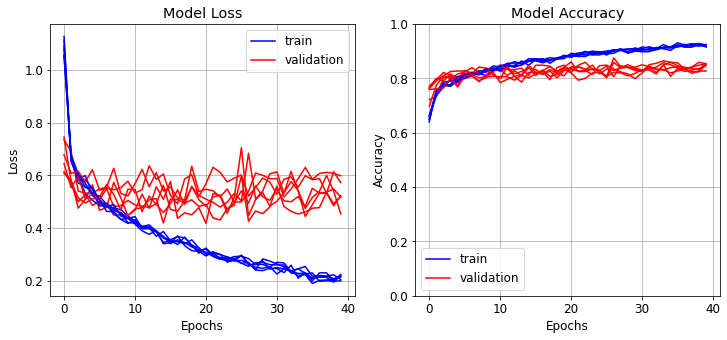

In [27]:
k = 6 # number of folds
alfa = 0.001 # learning rate
Lambda = 0 # regularizer
epochs = 40
batch_size = 16
acc14, loss14, model14 = k_fold_validation(x_train, y_train, 'model_VGG2', k, alfa, Lambda, epochs, batch_size)

## Different optimizers for the best model so far - Model VGG2

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Epoch 1/40
88/88 [==============================] - 12s 134ms/step - loss: 1.5083 - categorical_accuracy: 0.3728 - val_loss: 1.3612 - val_categorical_accuracy: 0.5429
Epoch 2/40
88/88 [==============================] - 11s 120ms/step - loss: 1.3095 - categorical_accuracy: 0.5311 - val_loss: 1.2008 - val_categorical_accuracy: 0.6071
Epoch 3/40
88/88 [==============================] - 11s 122ms/step - loss: 1.1792 - categorical_accuracy: 0.5980 - val_loss: 1.1120 - val_categorical_accuracy: 0.6179
Epoch 4/40
88/88 [==============================] - 11s 121ms/step - loss: 1.0946 - categorical_accuracy: 0.6322 - val_loss: 1.0224 - val_categorical_accuracy: 0.6625
Epoch 5/40
88/88 [==============================] - 11s 120ms/step - loss: 1.0304 - categorical_accuracy: 0.6485 - val_loss: 0.9581 - val_categorical_accuracy: 0.6696
Epoch 6/40
88/88 [=====

88/88 [==============================] - 11s 128ms/step - loss: 0.7619 - categorical_accuracy: 0.7374 - val_loss: 0.7254 - val_categorical_accuracy: 0.7594
Epoch 17/40
88/88 [==============================] - 11s 121ms/step - loss: 0.7621 - categorical_accuracy: 0.7285 - val_loss: 0.7093 - val_categorical_accuracy: 0.7754
Epoch 18/40
88/88 [==============================] - 11s 121ms/step - loss: 0.7404 - categorical_accuracy: 0.7456 - val_loss: 0.7039 - val_categorical_accuracy: 0.7754
Epoch 19/40
88/88 [==============================] - 11s 121ms/step - loss: 0.7257 - categorical_accuracy: 0.7431 - val_loss: 0.7019 - val_categorical_accuracy: 0.7736
Epoch 20/40
88/88 [==============================] - 11s 122ms/step - loss: 0.7183 - categorical_accuracy: 0.7466 - val_loss: 0.6920 - val_categorical_accuracy: 0.7772
Epoch 21/40
88/88 [==============================] - 13s 143ms/step - loss: 0.7051 - categorical_accuracy: 0.7537 - val_loss: 0.6831 - val_categorical_accuracy: 0.7897
Epoc

88/88 [==============================] - 11s 128ms/step - loss: 0.6571 - categorical_accuracy: 0.7633 - val_loss: 0.6517 - val_categorical_accuracy: 0.7576
Epoch 33/40
88/88 [==============================] - 11s 123ms/step - loss: 0.6561 - categorical_accuracy: 0.7644 - val_loss: 0.6505 - val_categorical_accuracy: 0.7558
Epoch 34/40
88/88 [==============================] - 12s 132ms/step - loss: 0.6507 - categorical_accuracy: 0.7644 - val_loss: 0.6407 - val_categorical_accuracy: 0.7594
Epoch 35/40
88/88 [==============================] - 11s 125ms/step - loss: 0.6373 - categorical_accuracy: 0.7708 - val_loss: 0.6358 - val_categorical_accuracy: 0.7718
Epoch 36/40
88/88 [==============================] - 11s 123ms/step - loss: 0.6302 - categorical_accuracy: 0.7701 - val_loss: 0.6434 - val_categorical_accuracy: 0.7504
Epoch 37/40
88/88 [==============================] - 12s 133ms/step - loss: 0.6457 - categorical_accuracy: 0.7690 - val_loss: 0.6401 - val_categorical_accuracy: 0.7629
Epoc

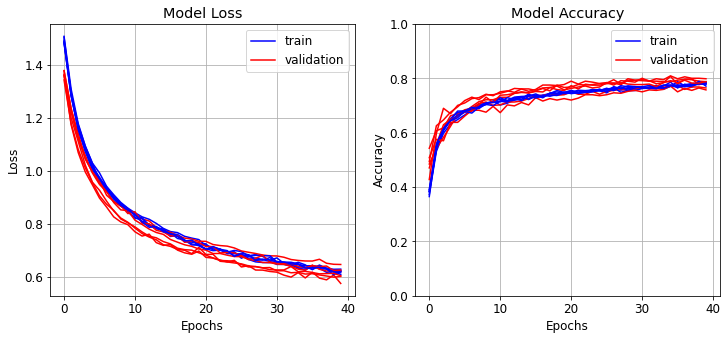

In [32]:
k = 6 # number of folds
alfa = 0.001 # learning rate
Lambda = 0 # regularizer
epochs = 40
batch_size = 32
acc16, loss16, model16 = k_fold_validation(x_train, y_train, 'model_VGG2_SGD', k, alfa, Lambda, epochs, batch_size)

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Epoch 1/40
88/88 [==============================] - 12s 140ms/step - loss: 2.1524 - categorical_accuracy: 0.5333 - val_loss: 1.0017 - val_categorical_accuracy: 0.6054
Epoch 2/40
88/88 [==============================] - 11s 121ms/step - loss: 0.8874 - categorical_accuracy: 0.6752 - val_loss: 0.6924 - val_categorical_accuracy: 0.7321
Epoch 3/40
88/88 [==============================] - 11s 124ms/step - loss: 0.7531 - categorical_accuracy: 0.7143 - val_loss: 0.6533 - val_categorical_accuracy: 0.7464
Epoch 4/40
88/88 [==============================] - 10s 119ms/step - loss: 0.6788 - categorical_accuracy: 0.7496 - val_loss: 0.6568 - val_categorical_accuracy: 0.7446
Epoch 5/40
88/88 [==============================] - 12s 135ms/step - loss: 0.6220 - categorical_accuracy: 0.7759 - val_loss: 0.5035 - val_categorical_accuracy: 0.8161
Epoch 6/40
88/88 [=====

88/88 [==============================] - 10s 118ms/step - loss: 0.4279 - categorical_accuracy: 0.8420 - val_loss: 0.5758 - val_categorical_accuracy: 0.8164
Epoch 17/40
88/88 [==============================] - 10s 117ms/step - loss: 0.3830 - categorical_accuracy: 0.8626 - val_loss: 0.5379 - val_categorical_accuracy: 0.8200
Epoch 18/40
88/88 [==============================] - 10s 119ms/step - loss: 0.3860 - categorical_accuracy: 0.8566 - val_loss: 0.4973 - val_categorical_accuracy: 0.8307
Epoch 19/40
88/88 [==============================] - 10s 118ms/step - loss: 0.3760 - categorical_accuracy: 0.8637 - val_loss: 0.5718 - val_categorical_accuracy: 0.8146
Epoch 20/40
88/88 [==============================] - 10s 118ms/step - loss: 0.3532 - categorical_accuracy: 0.8779 - val_loss: 0.5214 - val_categorical_accuracy: 0.8538
Epoch 21/40
88/88 [==============================] - 10s 118ms/step - loss: 0.3849 - categorical_accuracy: 0.8573 - val_loss: 0.5293 - val_categorical_accuracy: 0.8467
Epoc

88/88 [==============================] - 12s 141ms/step - loss: 0.2898 - categorical_accuracy: 0.9000 - val_loss: 0.6846 - val_categorical_accuracy: 0.8396
Epoch 33/40
88/88 [==============================] - 13s 147ms/step - loss: 0.2878 - categorical_accuracy: 0.8975 - val_loss: 0.7128 - val_categorical_accuracy: 0.8378
Epoch 34/40
88/88 [==============================] - 13s 152ms/step - loss: 0.2953 - categorical_accuracy: 0.8975 - val_loss: 0.6411 - val_categorical_accuracy: 0.8396
Epoch 35/40
88/88 [==============================] - 12s 137ms/step - loss: 0.2854 - categorical_accuracy: 0.8993 - val_loss: 0.6809 - val_categorical_accuracy: 0.8360
Epoch 36/40
88/88 [==============================] - 11s 121ms/step - loss: 0.2642 - categorical_accuracy: 0.9096 - val_loss: 0.6917 - val_categorical_accuracy: 0.8289
Epoch 37/40
88/88 [==============================] - 11s 119ms/step - loss: 0.2614 - categorical_accuracy: 0.9128 - val_loss: 0.9098 - val_categorical_accuracy: 0.8057
Epoc

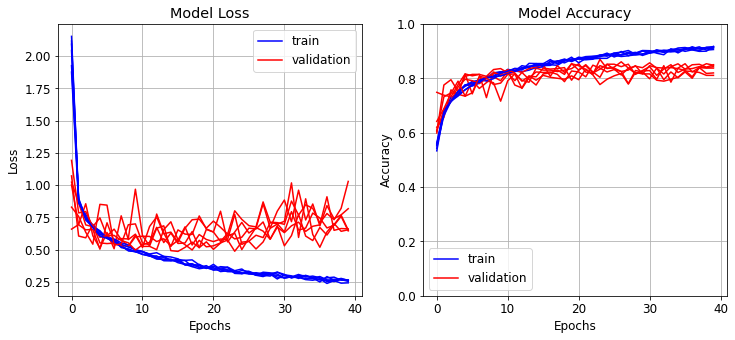

In [28]:
k = 6 # number of folds
alfa = 0.001 # learning rate
Lambda = 0 # regularizer
epochs = 40
batch_size = 32
acc16, loss16, model16 = k_fold_validation(x_train, y_train, 'model_VGG2_RMS', k, alfa, Lambda, epochs, batch_size)

## Testing without data augmentation - Model VGG2

[INFO] Performing 6-fold validation...
------------------------------------------------------------------------
[INFO] Training for fold no 0
Train on 2811 samples, validate on 560 samples
Epoch 1/40
2811/2811 [==============================] - 9s 3ms/step - loss: 1.0534 - categorical_accuracy: 0.6816 - val_loss: 0.6351 - val_categorical_accuracy: 0.7500
Epoch 2/40
2811/2811 [==============================] - 9s 3ms/step - loss: 0.4440 - categorical_accuracy: 0.8399 - val_loss: 0.5063 - val_categorical_accuracy: 0.8107
Epoch 3/40
2811/2811 [==============================] - 9s 3ms/step - loss: 0.3324 - categorical_accuracy: 0.8830 - val_loss: 0.4718 - val_categorical_accuracy: 0.8196
Epoch 4/40
2811/2811 [==============================] - 9s 3ms/step - loss: 0.2005 - categorical_accuracy: 0.9328 - val_loss: 0.5460 - val_categorical_accuracy: 0.8089
Epoch 5/40
2811/2811 [==============================] - 9s 3ms/step - loss: 0.1313 - categorical_accuracy: 0.9605 - val_loss: 0.4727 - val_

2810/2810 [==============================] - 9s 3ms/step - loss: 0.1646 - categorical_accuracy: 0.9495 - val_loss: 0.9069 - val_categorical_accuracy: 0.7647
Epoch 15/40
2810/2810 [==============================] - 9s 3ms/step - loss: 0.1855 - categorical_accuracy: 0.9352 - val_loss: 0.7280 - val_categorical_accuracy: 0.8307
Epoch 16/40
2810/2810 [==============================] - 9s 3ms/step - loss: 0.0830 - categorical_accuracy: 0.9726 - val_loss: 0.8008 - val_categorical_accuracy: 0.8271
Epoch 17/40
2810/2810 [==============================] - 9s 3ms/step - loss: 0.0309 - categorical_accuracy: 0.9897 - val_loss: 0.8358 - val_categorical_accuracy: 0.8182
Epoch 18/40
2810/2810 [==============================] - 9s 3ms/step - loss: 0.0170 - categorical_accuracy: 0.9957 - val_loss: 0.8799 - val_categorical_accuracy: 0.8146
Epoch 19/40
2810/2810 [==============================] - 9s 3ms/step - loss: 0.0054 - categorical_accuracy: 0.9996 - val_loss: 1.0329 - val_categorical_accuracy: 0.807

Epoch 28/40
2810/2810 [==============================] - 10s 4ms/step - loss: 3.6968e-04 - categorical_accuracy: 1.0000 - val_loss: 0.8530 - val_categorical_accuracy: 0.8217
Epoch 29/40
2810/2810 [==============================] - 10s 4ms/step - loss: 3.3862e-04 - categorical_accuracy: 1.0000 - val_loss: 0.8555 - val_categorical_accuracy: 0.8253
Epoch 30/40
2810/2810 [==============================] - 10s 3ms/step - loss: 3.0950e-04 - categorical_accuracy: 1.0000 - val_loss: 0.8613 - val_categorical_accuracy: 0.8289ETA: 0s - loss: 3.0936e-04 - categorical_accuracy: 1.
Epoch 31/40
2810/2810 [==============================] - 9s 3ms/step - loss: 2.8540e-04 - categorical_accuracy: 1.0000 - val_loss: 0.8664 - val_categorical_accuracy: 0.8289
Epoch 32/40
2810/2810 [==============================] - 9s 3ms/step - loss: 2.6455e-04 - categorical_accuracy: 1.0000 - val_loss: 0.8712 - val_categorical_accuracy: 0.8253
Epoch 33/40
2810/2810 [==============================] - 10s 3ms/step - loss: 2

Epoch 35/40
2810/2810 [==============================] - 10s 3ms/step - loss: 0.0046 - categorical_accuracy: 0.9996 - val_loss: 1.0162 - val_categorical_accuracy: 0.8146
Epoch 36/40
2810/2810 [==============================] - 10s 3ms/step - loss: 0.0041 - categorical_accuracy: 0.9996 - val_loss: 0.9901 - val_categorical_accuracy: 0.8021
Epoch 37/40
2810/2810 [==============================] - 10s 4ms/step - loss: 0.0063 - categorical_accuracy: 0.9993 - val_loss: 1.0374 - val_categorical_accuracy: 0.7932
Epoch 38/40
2810/2810 [==============================] - 10s 4ms/step - loss: 0.0114 - categorical_accuracy: 0.9964 - val_loss: 1.0079 - val_categorical_accuracy: 0.8146
Epoch 39/40
2810/2810 [==============================] - 10s 4ms/step - loss: 0.0070 - categorical_accuracy: 0.9989 - val_loss: 0.9413 - val_categorical_accuracy: 0.8146
Epoch 40/40
2810/2810 [==============================] - 10s 3ms/step - loss: 0.0042 - categorical_accuracy: 0.9996 - val_loss: 0.9635 - val_categoric

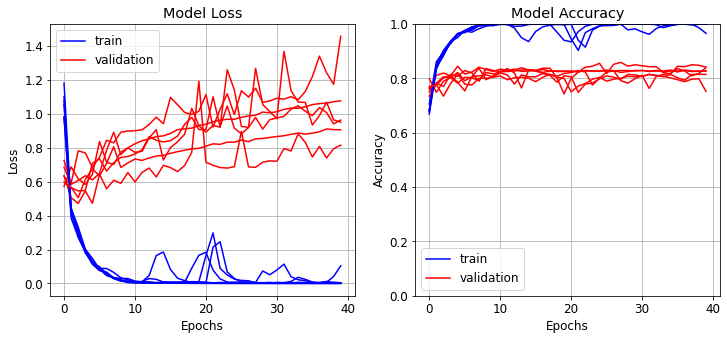

In [30]:
 # No Aug
k = 6 # number of folds
alfa = 0.001 # learning rate
Lambda = 0 # regularizer
epochs = 40
batch_size = 32
acc16, loss16, model16 = k_fold_validation(x_train, y_train, 'model_VGG2', k, alfa, Lambda, epochs, batch_size)

## Final test for the best model - Model VGG2

In [26]:
alfa = 0.001 # learning rate
Lambda = 0 # regularizer
epochs = 50
batch_size = 16

# define the architecture of the network
model = model_VGG2(x_train, y_train, alfa, Lambda)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=alfa), metrics=["categorical_accuracy"])

# training on train data
model.fit(train_datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs, 
                            steps_per_epoch=ceil(len(x_train)/batch_size), verbose=1)

# final test
print("[INFO] evaluating on testing set...")
(loss, accuracy) = model.evaluate(x_test, y_test)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss, accuracy * 100))

# weight saving
model.save_weights('model.h5')

Epoch 1/50
211/211 [==============================] - 18s 83ms/step - loss: 0.9966 - categorical_accuracy: 0.6630
Epoch 2/50
211/211 [==============================] - 13s 60ms/step - loss: 0.6496 - categorical_accuracy: 0.7520
Epoch 3/50
211/211 [==============================] - 13s 60ms/step - loss: 0.5849 - categorical_accuracy: 0.78260s - loss: 0.5812 - cate
Epoch 4/50
211/211 [==============================] - 13s 60ms/step - loss: 0.5378 - categorical_accuracy: 0.7944
Epoch 5/50
211/211 [==============================] - 13s 60ms/step - loss: 0.4989 - categorical_accuracy: 0.8057
Epoch 6/50
211/211 [==============================] - 13s 60ms/step - loss: 0.5005 - categorical_accuracy: 0.8069
Epoch 7/50
211/211 [==============================] - 14s 65ms/step - loss: 0.4735 - categorical_accuracy: 0.8241
Epoch 8/50
211/211 [==============================] - 14s 67ms/step - loss: 0.4580 - categorical_accuracy: 0.8276
Epoch 9/50
211/211 [==============================] - 13s 64ms/s

## Confusion matrix

In [28]:
predictions = model.predict(x_test)

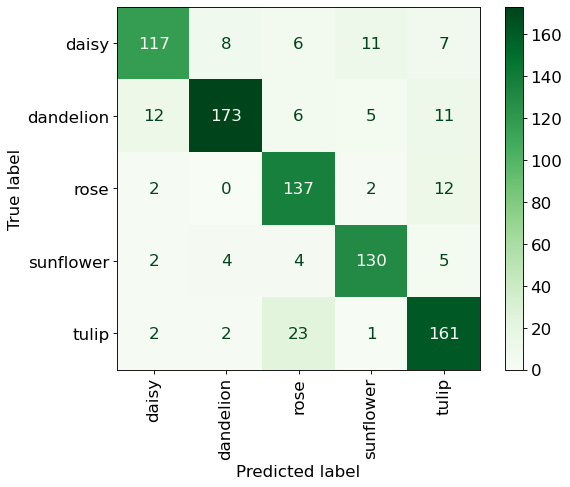

In [31]:
cm = confusion_matrix(np.argmax(y_test[:], axis=1), np.argmax(predictions[:],axis=1))

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 15})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp = disp.plot(cmap=plt.cm.Greens, xticks_rotation='vertical', values_format="d", ax = plt.axes())

In [32]:
accuracy = sum(np.diag(cm)) / np.sum(cm)
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

print('accuracy:')
print(accuracy)
print('recall:')
print(np.mean(recall))
print('precision:')
print(np.mean(precision))

f1 =[]
for i in range(0,5):
    f1.append(2*recall[i]*precision[i]/(recall[i]+precision[i]))
print('f1:')
print(np.mean(f1))

accuracy:
0.8517200474495848
recall:
0.852962420838096
precision:
0.8528242480640822
f1:
0.8511320752769838


## Correct labeling examples

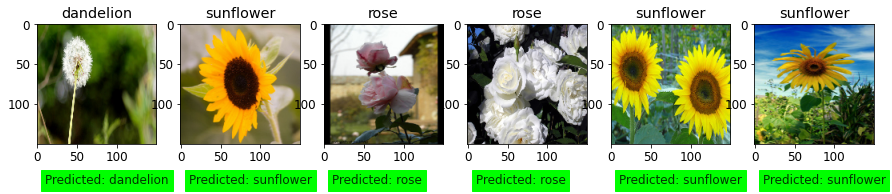

In [47]:
good_class = []
wrong_class = []
for i in range(0, np.shape(y_test)[0]):
    if np.argmax(y_test[i]) == np.argmax(predictions[i]):
        good_class.append(i)
    else:
        wrong_class.append(i)
        
x_test_recovered = x_test.reshape(len(x_test),IMG_SIZE,IMG_SIZE,3)
x_test_recovered = np.uint8(x_test_recovered * 255.0) 

good_class = shuffle(good_class)
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(1, 6)
fig.set_size_inches(15, 5)
for i in range(min(6, np.size(good_class))):
    x = good_class[i]
    floverBGR = (x_test_recovered[x]) #image loaded in BGR
    floverRGB = cv2.cvtColor(floverBGR, cv2.COLOR_BGR2RGB) #for proper color space in imshow change temporary to RGB
    ax[i].imshow(floverRGB)
    ax[i].set_title(le.classes_[np.argmax(y_test[x])])
    ax[i].text(10, 200, 'Predicted: %s' % le.classes_[np.argmax(predictions[x])], color='k', backgroundcolor='lime', alpha=0.8)
plt.show()

## Incorrect labeling examples

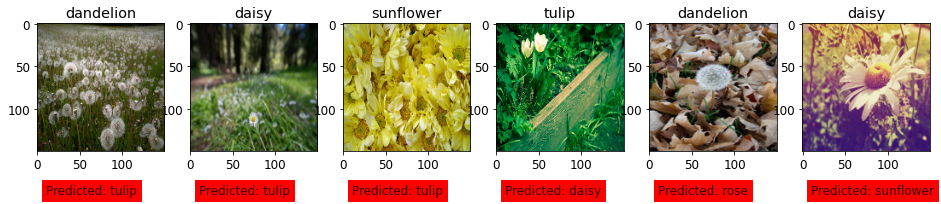

In [125]:
wrong_class = shuffle(wrong_class)
fig, ax = plt.subplots(1, 6)
fig.set_size_inches(16, 5)
for i in range(min(6, np.size(wrong_class))):
    x = wrong_class[i]
    floverBGR = (x_test_recovered[x]) #image loaded in BGR
    floverRGB = cv2.cvtColor(floverBGR, cv2.COLOR_BGR2RGB) #for proper color space in imshow change temporary to RGB
    ax[i].imshow(floverRGB)
    ax[i].set_title(le.classes_[np.argmax(y_test[x])])
    ax[i].text(10, 200, 'Predicted: %s' % le.classes_[np.argmax(predictions[x])], color='k', backgroundcolor='red', alpha=0.8)
plt.show()